# Set Up Your Environment

Install necessary tools

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, count, lit, when, max as spark_max, min as spark_min
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow dask


Install PySpark via pip

In [ ]:
pip install pyspark


Verify Installation

In [3]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.master("local[*]").appName("PySparkTest").getOrCreate()

# Check Spark version
print("Spark version:", spark.version)


Spark version: 3.5.4


List Uploaded Files

In [4]:
import os

# List all files in the 'content' directory
uploaded_files = os.listdir('/content')
print("Uploaded Files:", uploaded_files)


Uploaded Files: ['.config', 'fh_5yrs.csv', '.ipynb_checkpoints', 'sample_data']


Load All Files

In [5]:
df = spark.read.csv(f'/content/fh_5yrs.csv', header=True, inferSchema=True)


In order to analyse further, sample of data belong to 6 companies analyze further

In [6]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder.master("local[*]").appName("StockDataAnalysis").getOrCreate()

# Load all CSV files from the content folder
combined_df = spark.read.csv('/content/*.csv', header=True, inferSchema=True)
combined_df.show(5)  # Display the first 5 rows
combined_df.printSchema()  # Check the structure of the dataset


+----------+------+------------------+------------------+------------------+------------------+------------------+------+
|      date|volume|              open|              high|               low|             close|          adjclose|symbol|
+----------+------+------------------+------------------+------------------+------------------+------------------+------+
|2020-07-02|257500|17.639999389648438|17.739999771118164|  17.6200008392334|17.709999084472656|17.709999084472656|  AAAU|
|2020-07-01|468100|17.729999542236328|17.729999542236328|17.540000915527347| 17.68000030517578| 17.68000030517578|  AAAU|
|2020-06-30|319100|17.649999618530273|17.799999237060547|17.610000610351562|17.780000686645508|17.780000686645508|  AAAU|
|2020-06-29|405500|17.670000076293945|17.690000534057614|  17.6299991607666| 17.68000030517578| 17.68000030517578|  AAAU|
|2020-06-26|335100|17.489999771118164|17.670000076293945|17.420000076293945|17.670000076293945|17.670000076293945|  AAAU|
+----------+------+-----

 Identify the Target Variable

In [ ]:
if 'close' in df.columns:
    print("Target variable 'close' exists in the dataset.")
else:
    print("Target variable 'close' not found. Check column names:", df.columns)


Target variable 'close' exists in the dataset.


## Predictive Analysis

In [7]:
# Convert PySpark DataFrame to Pandas
pandas_df = df.toPandas()

# Ensure `Date` column is in datetime format for better handling
pandas_df['date'] = pandas_df['date'].astype('datetime64[ns]')



In [8]:
from pyspark.sql.functions import corr # Import the corr function

df.select(corr("close", "volume").alias("correlation")).show()

+-------------------+
|        correlation|
+-------------------+
|0.02466350214349392|
+-------------------+



Perform Stock Price Prediction

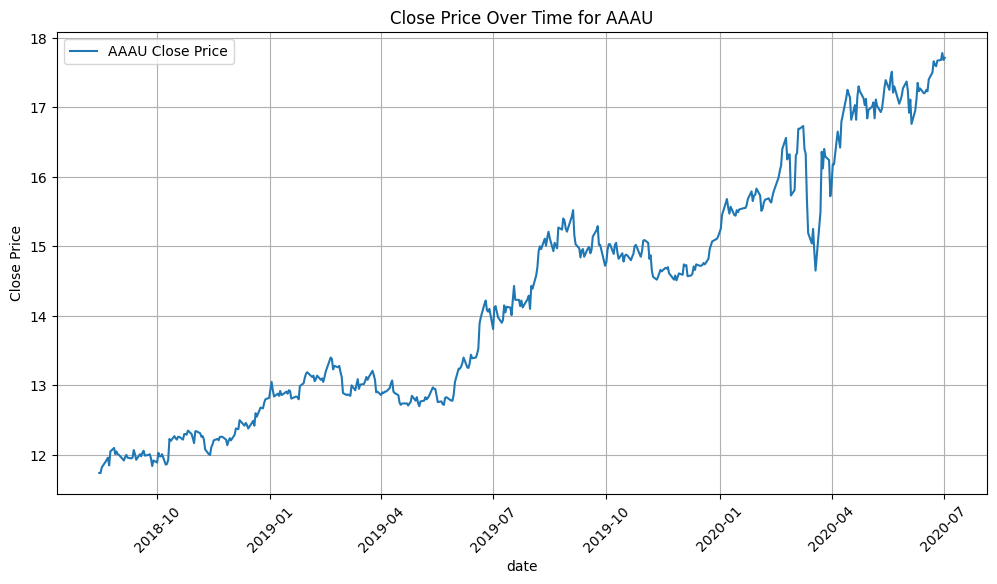

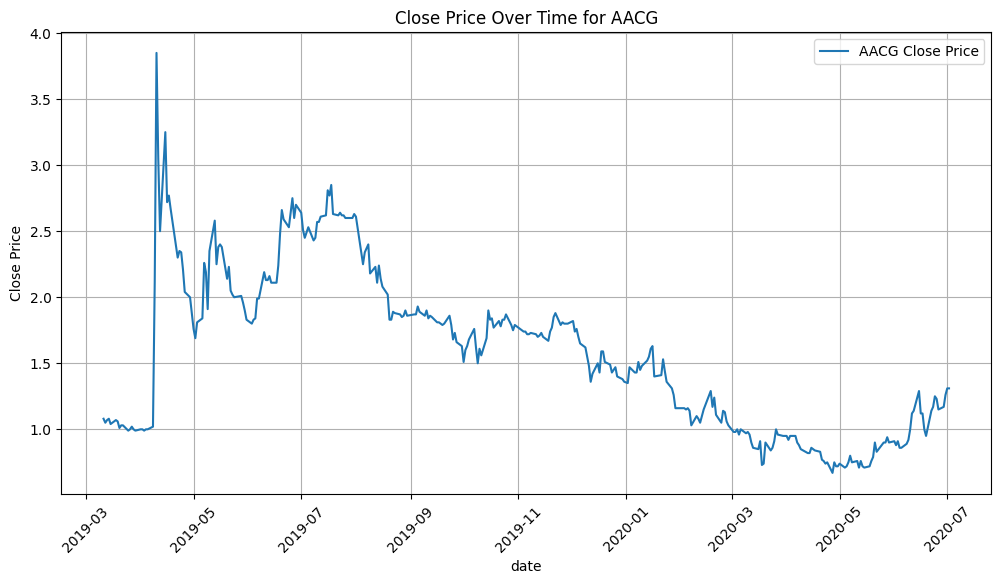

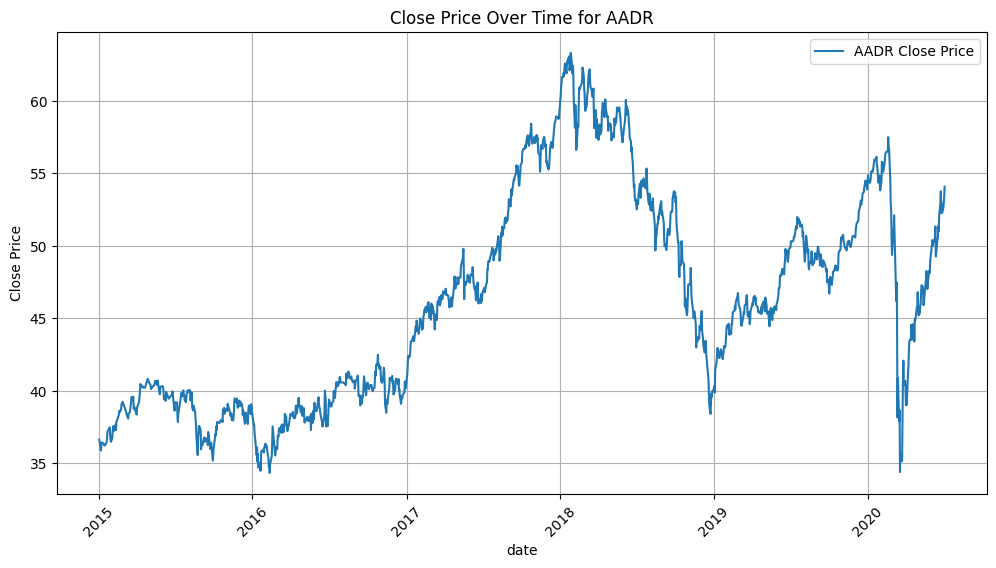

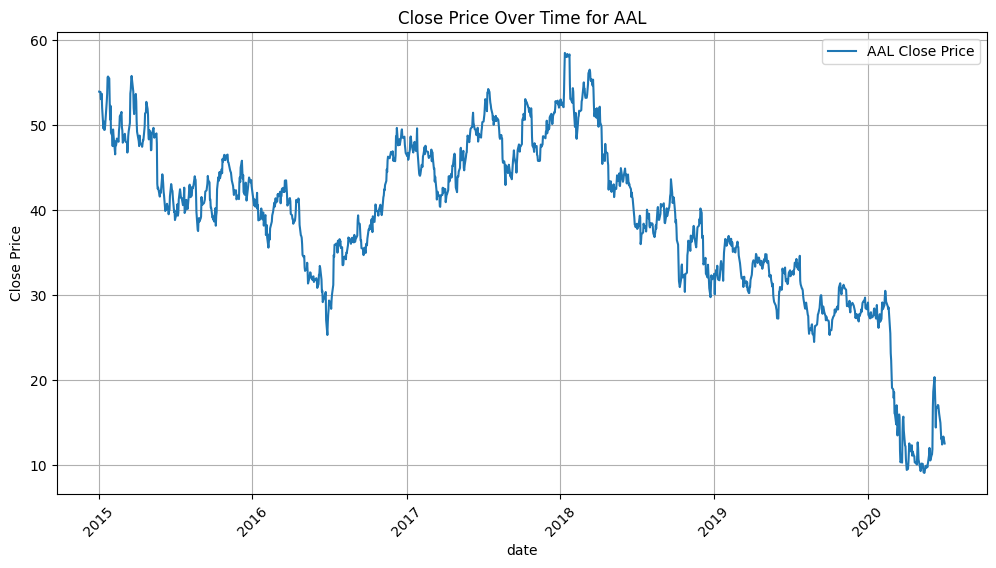

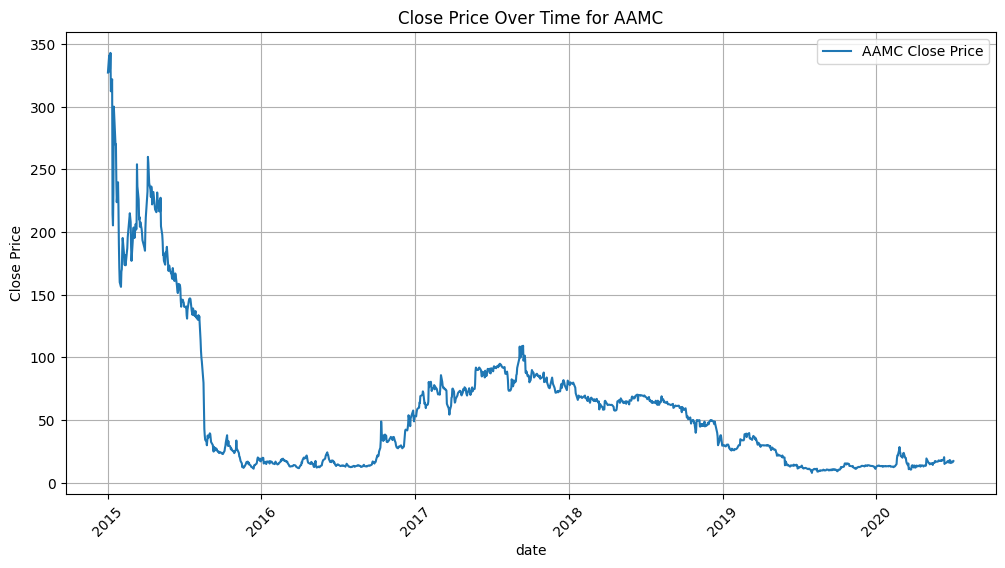

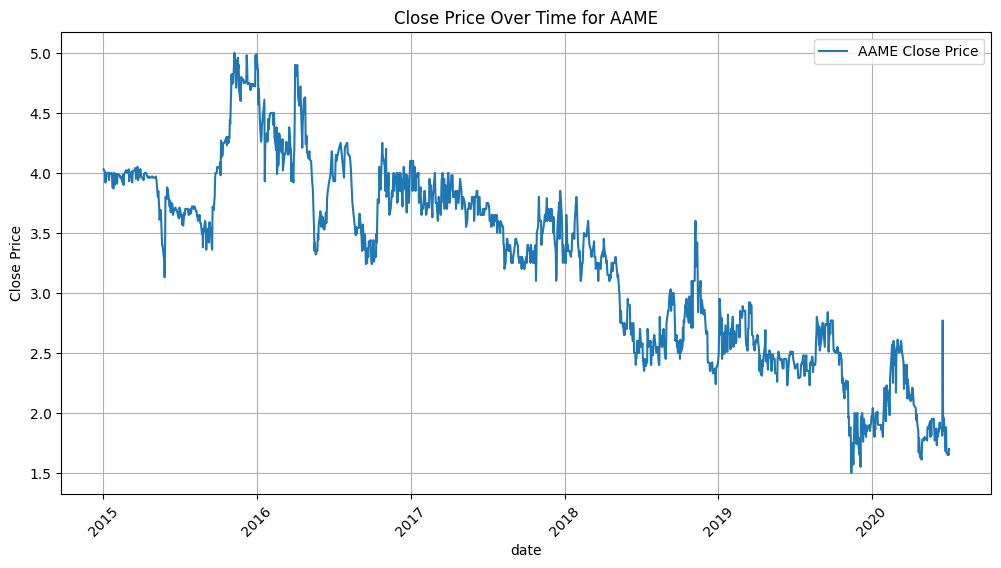

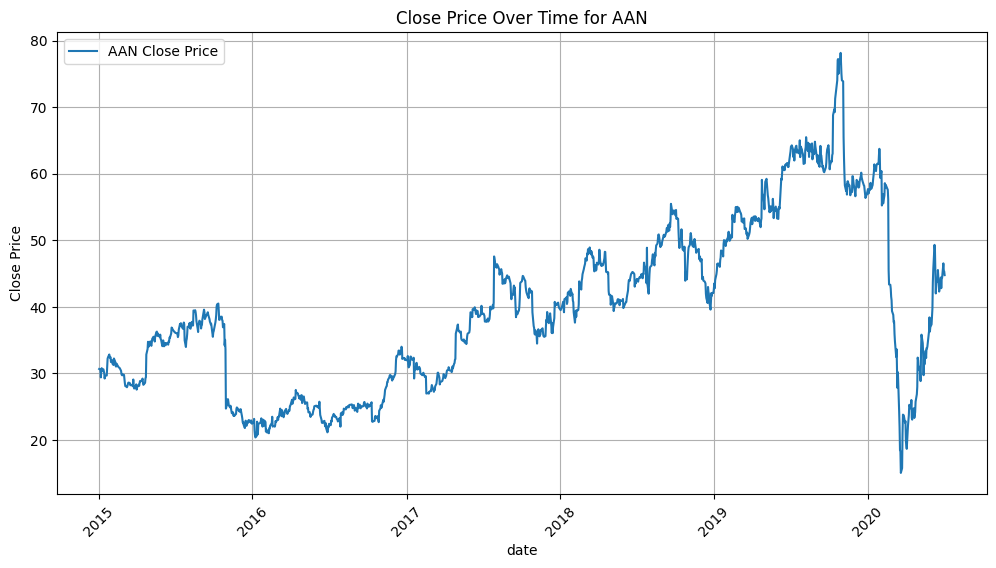

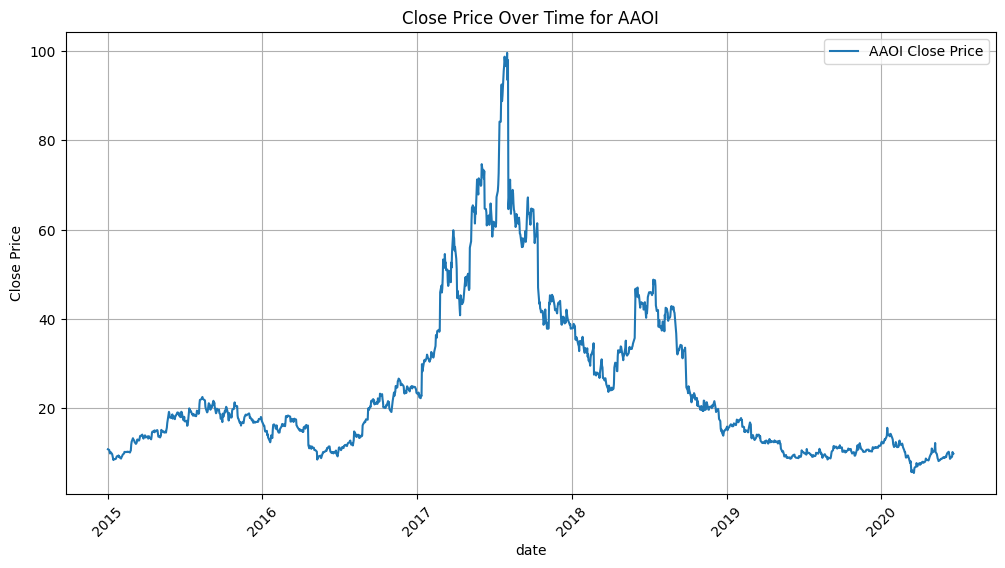

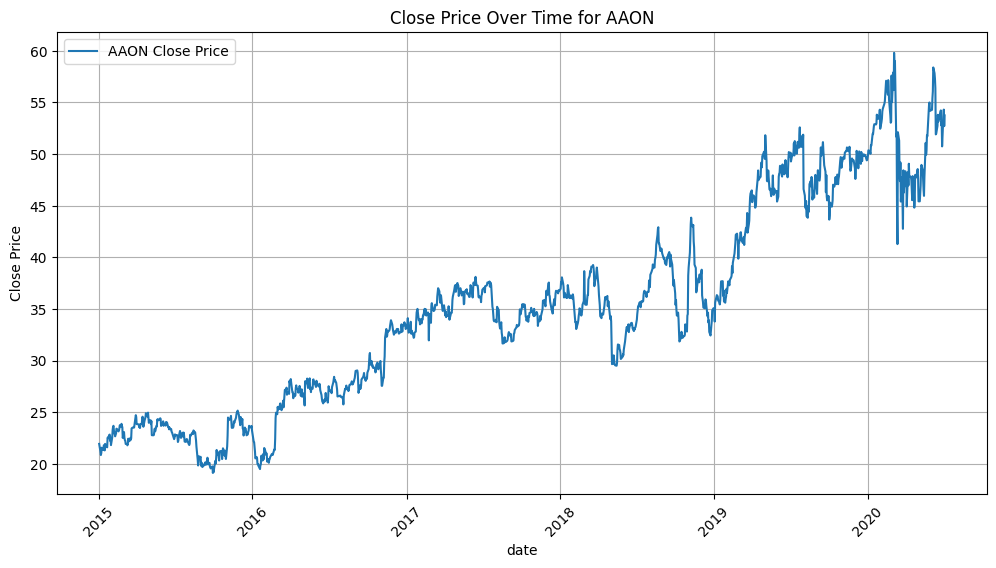

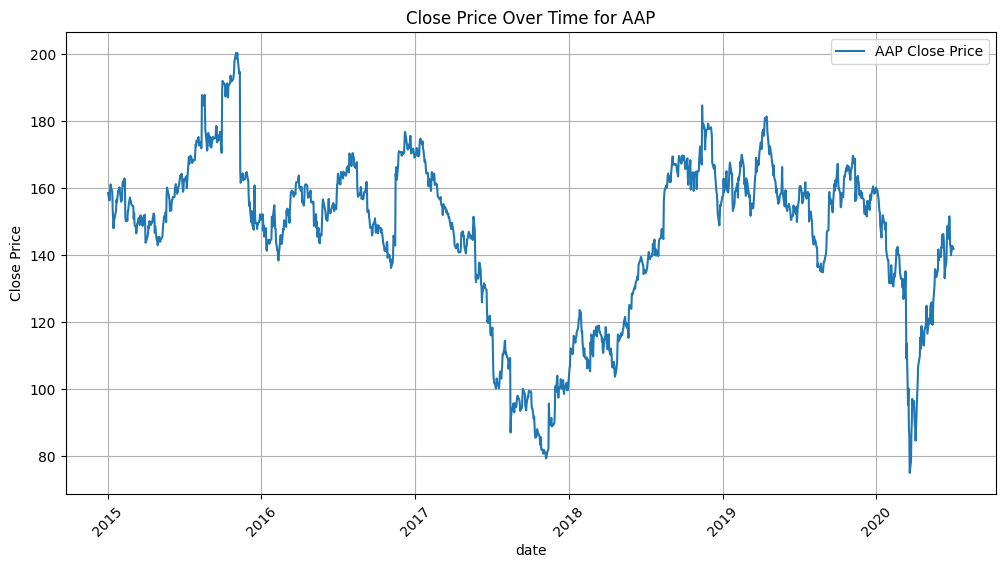

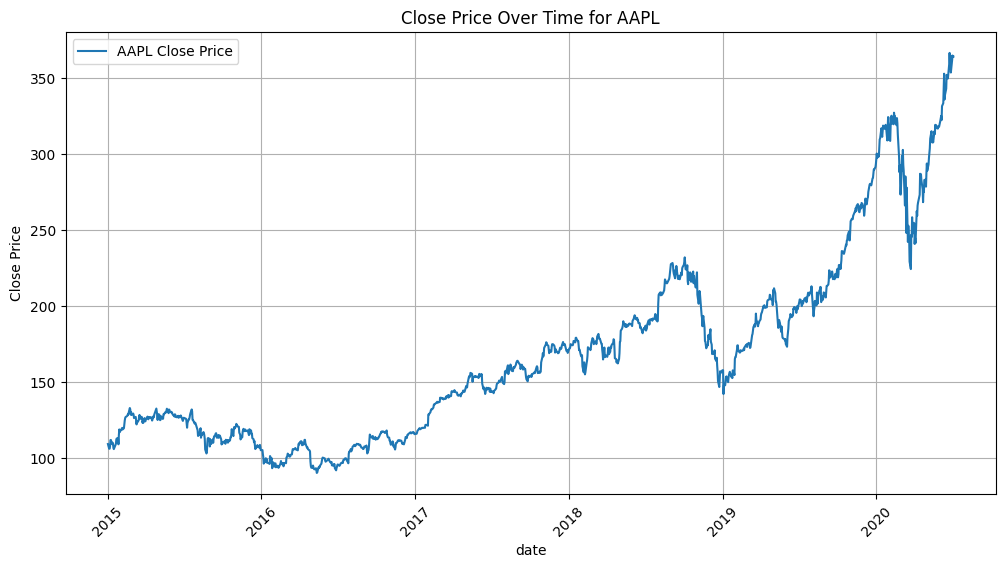

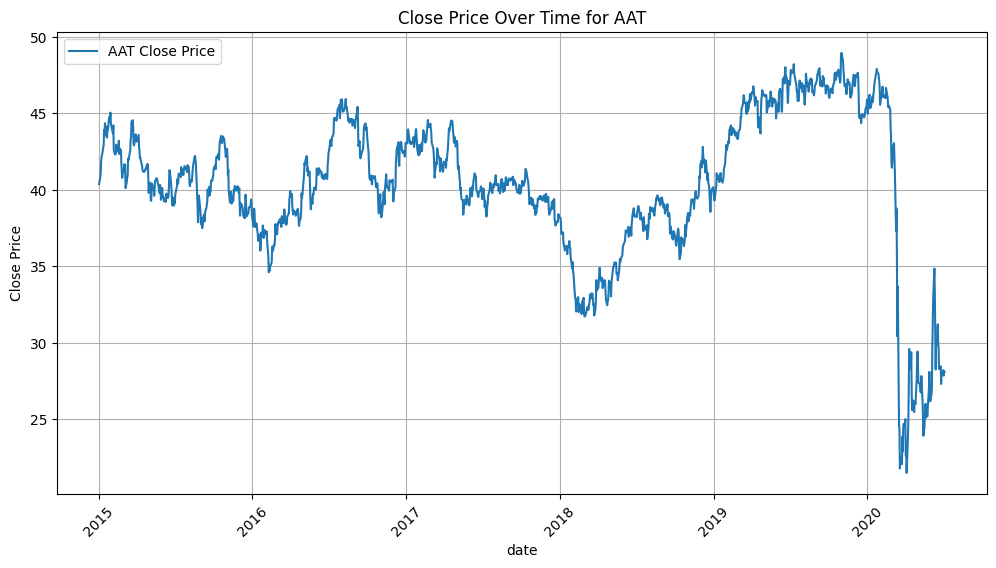

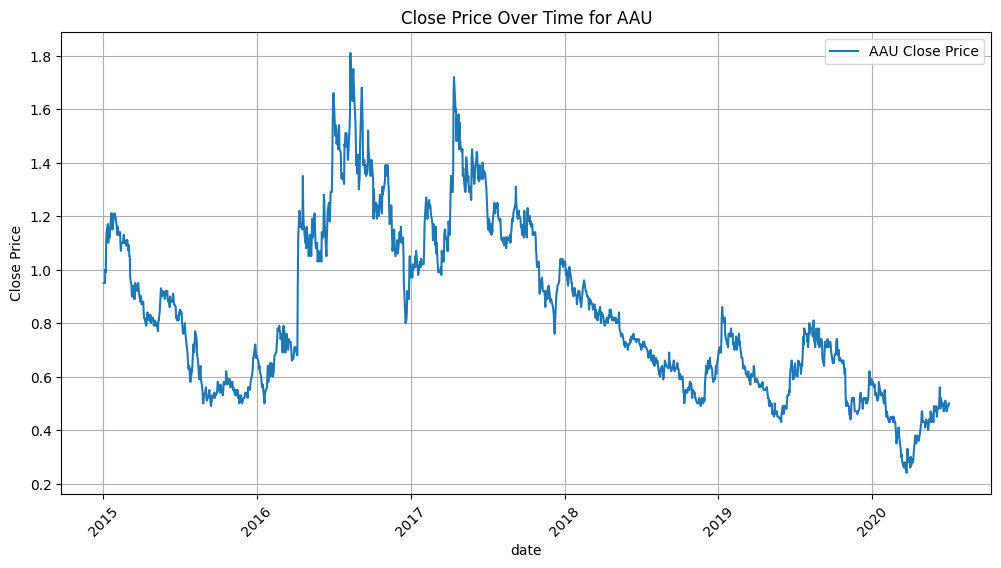

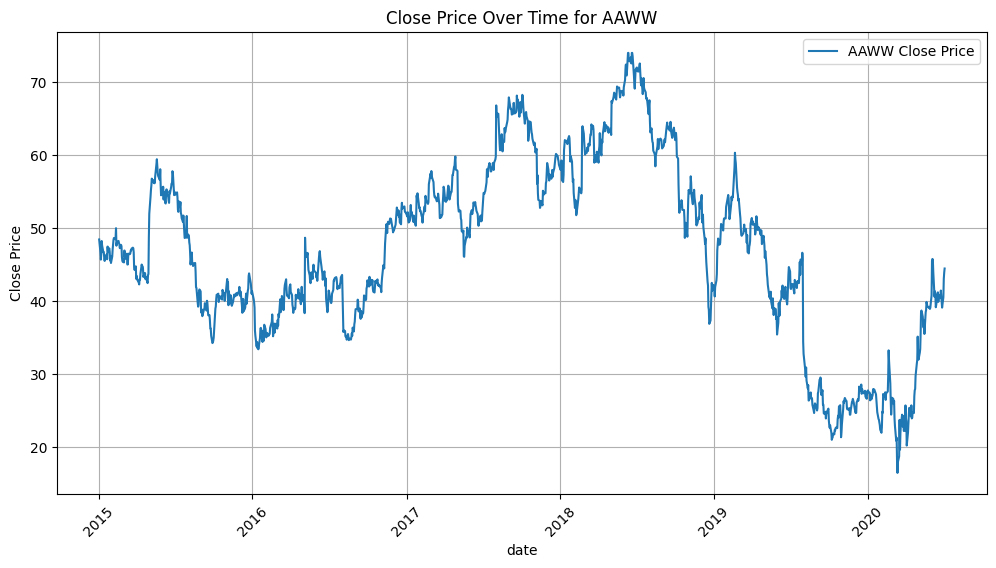

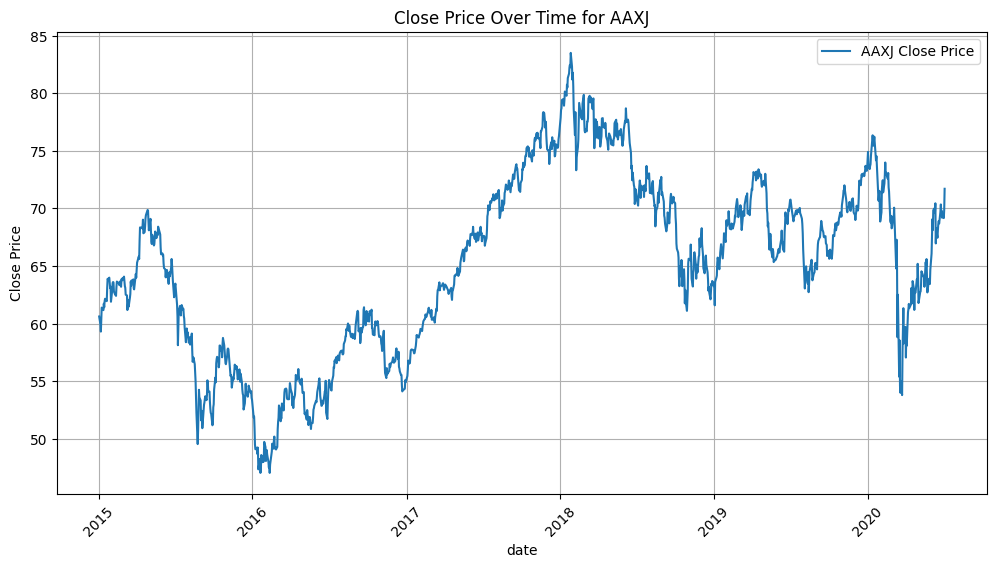

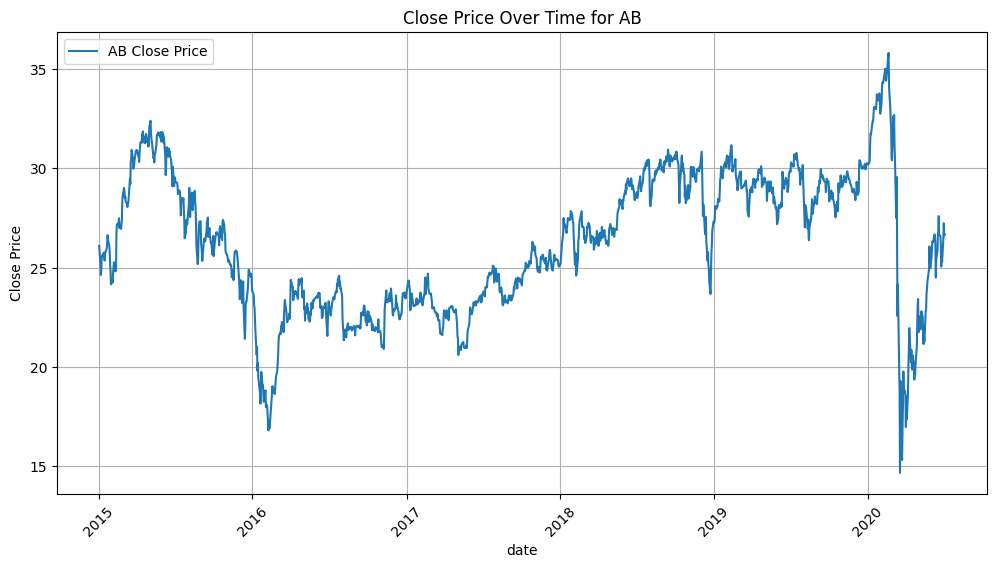

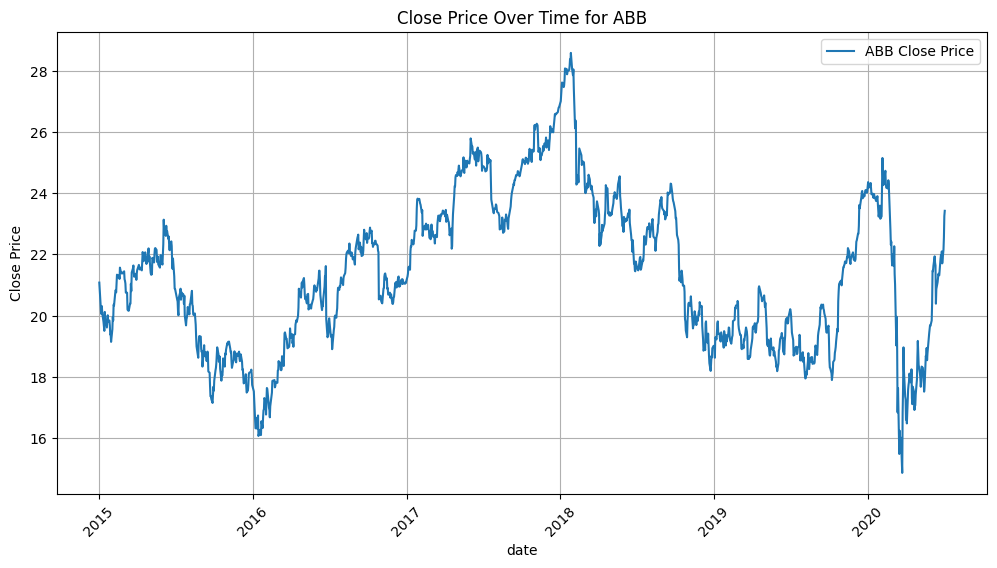

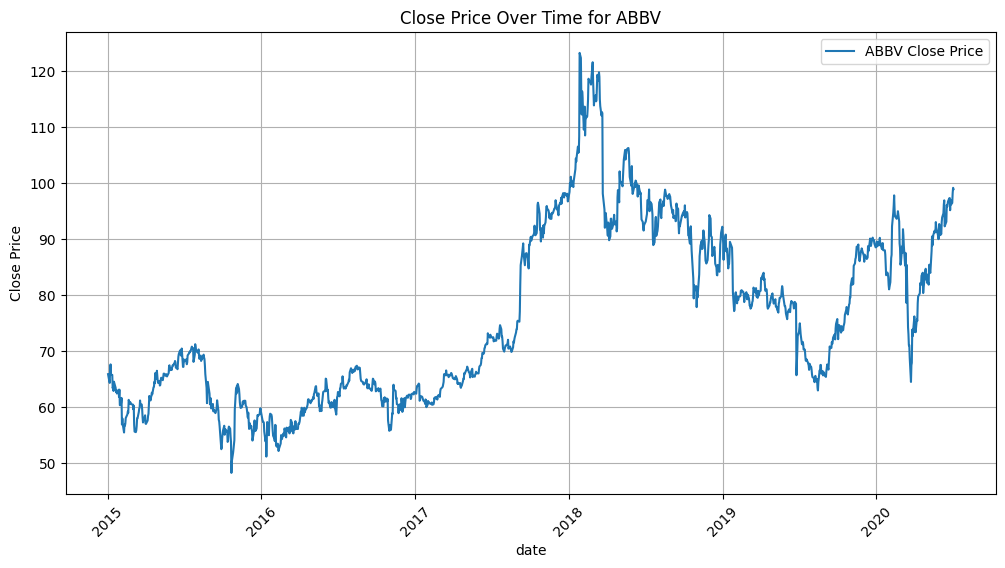

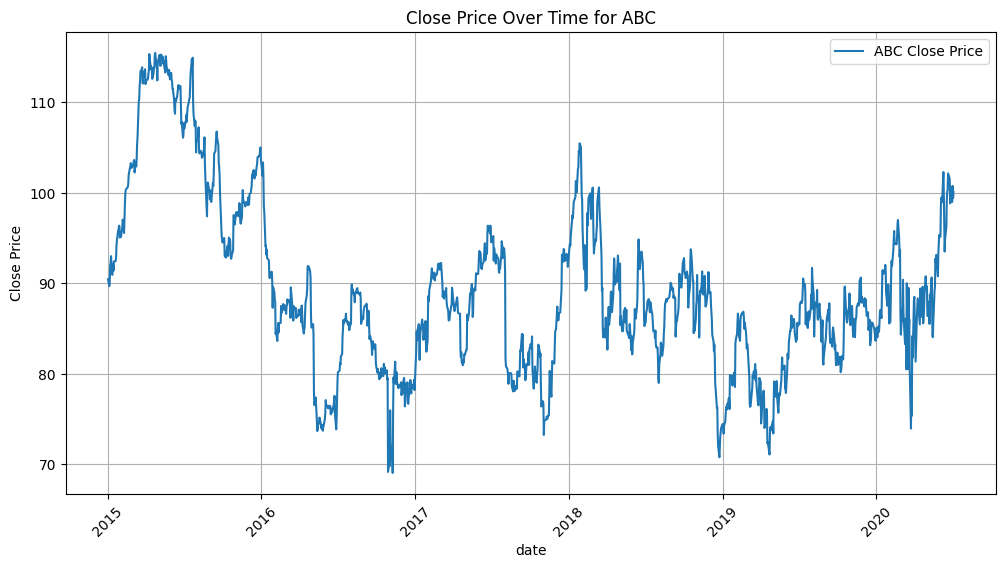

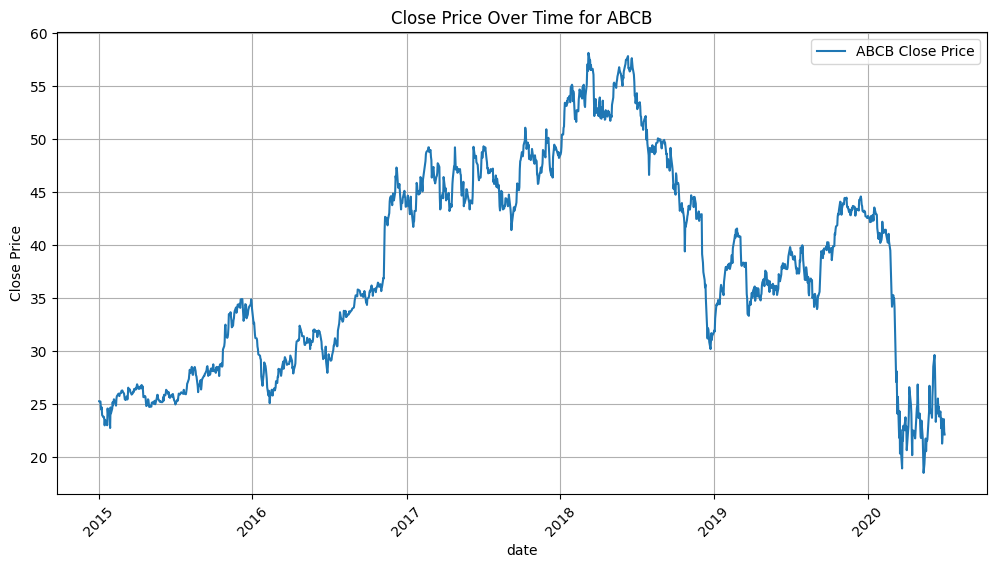

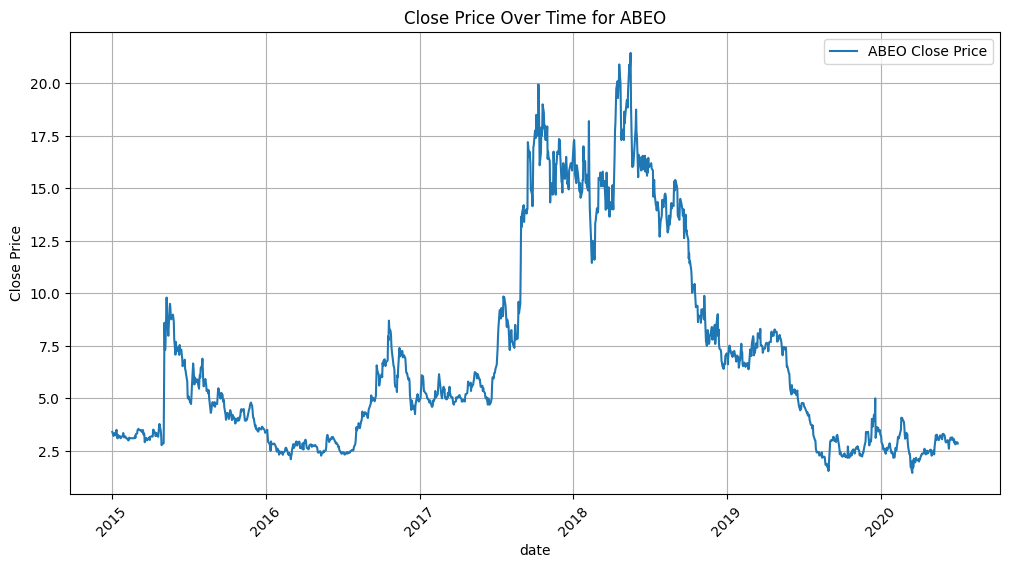

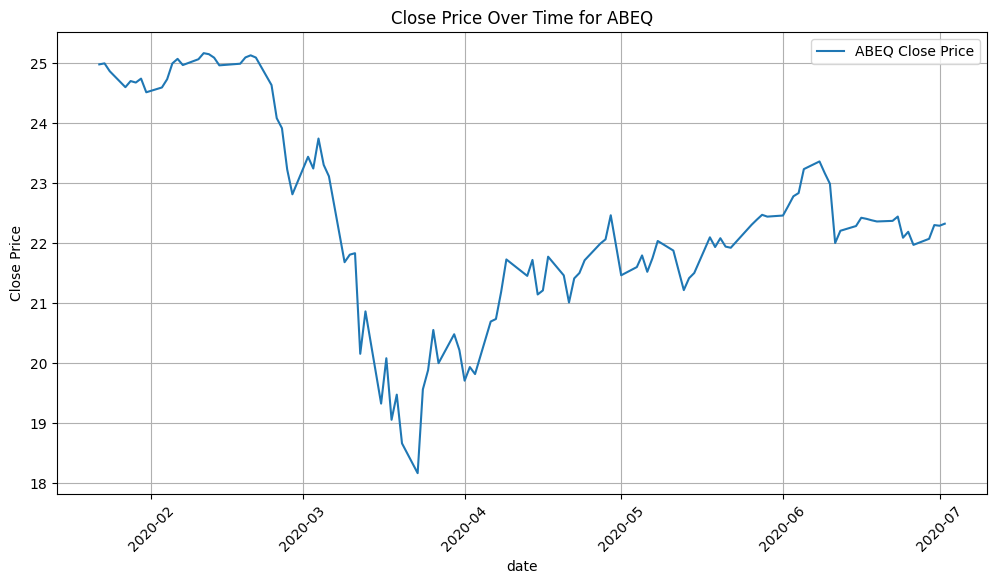

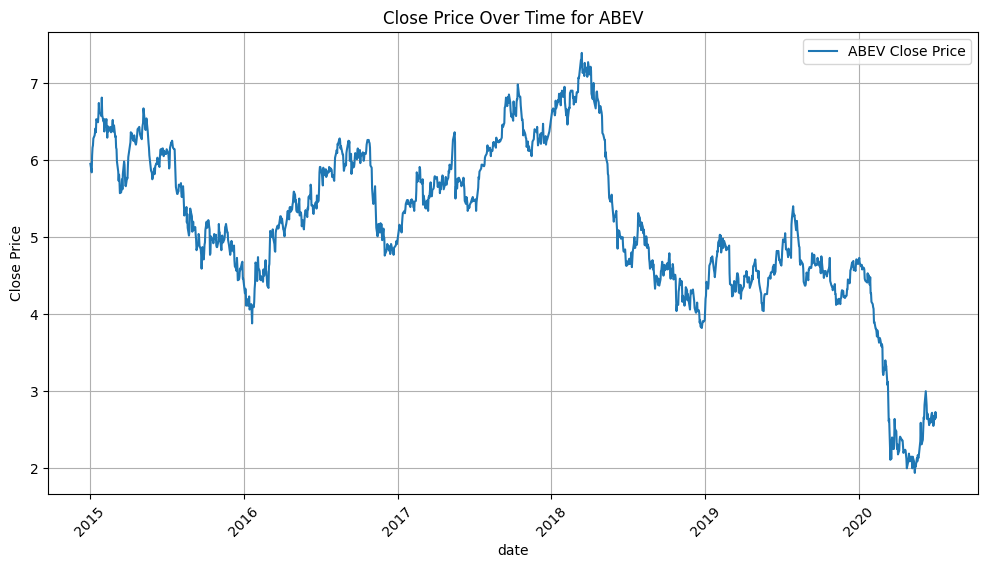

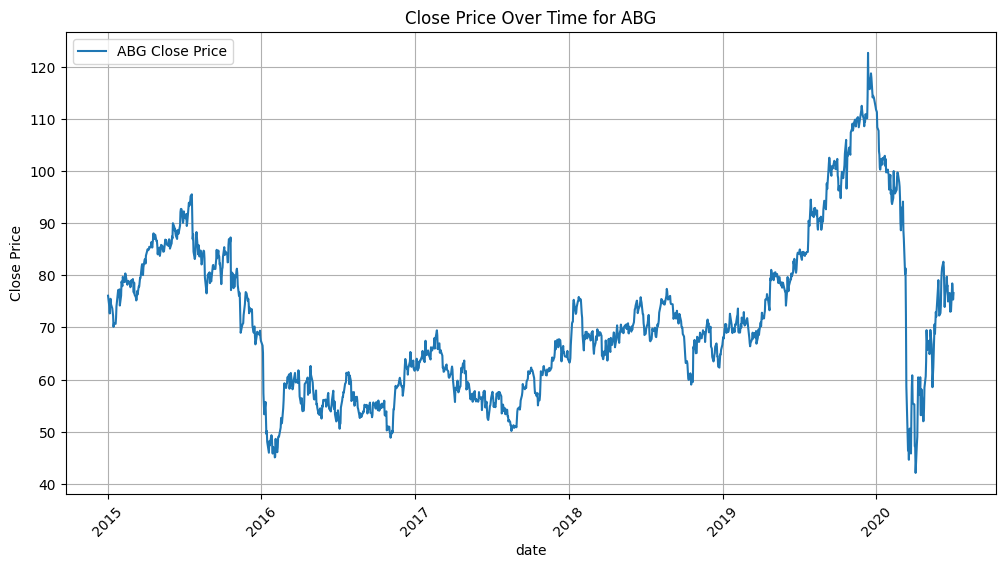

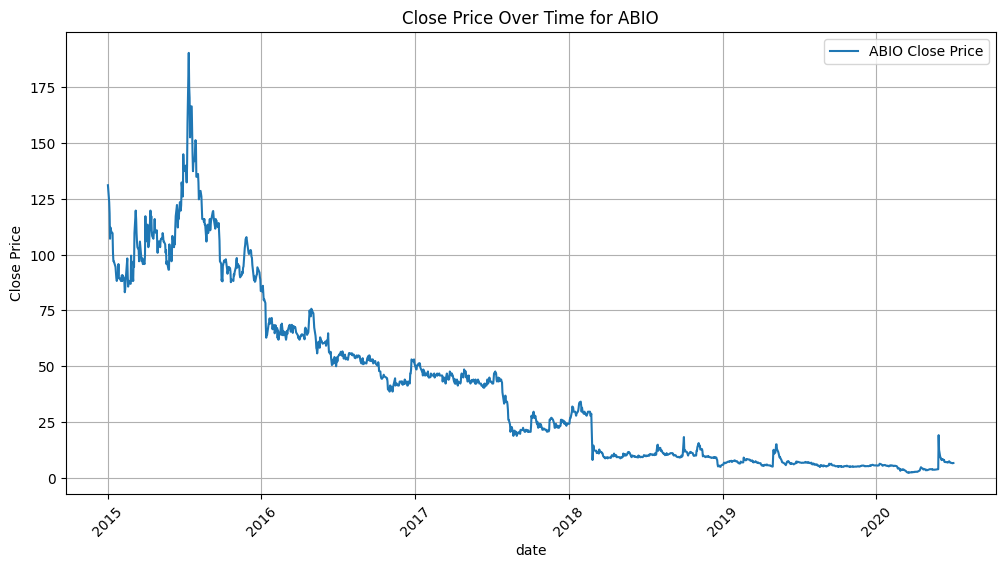

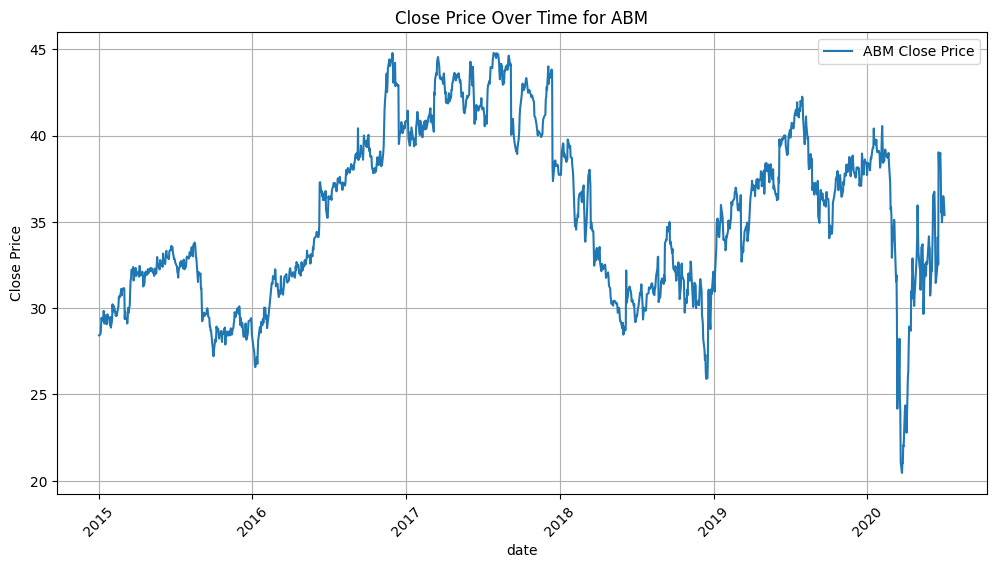

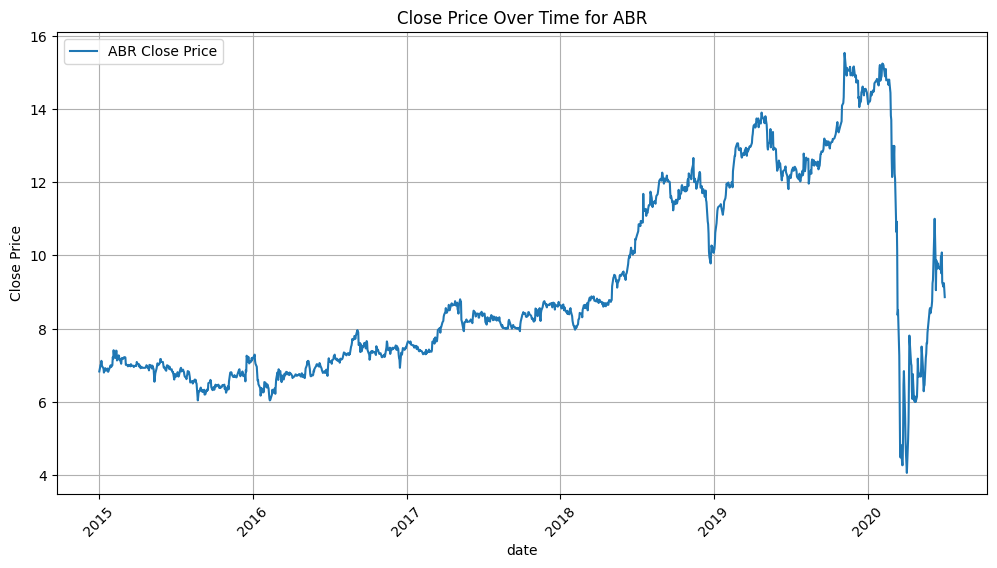

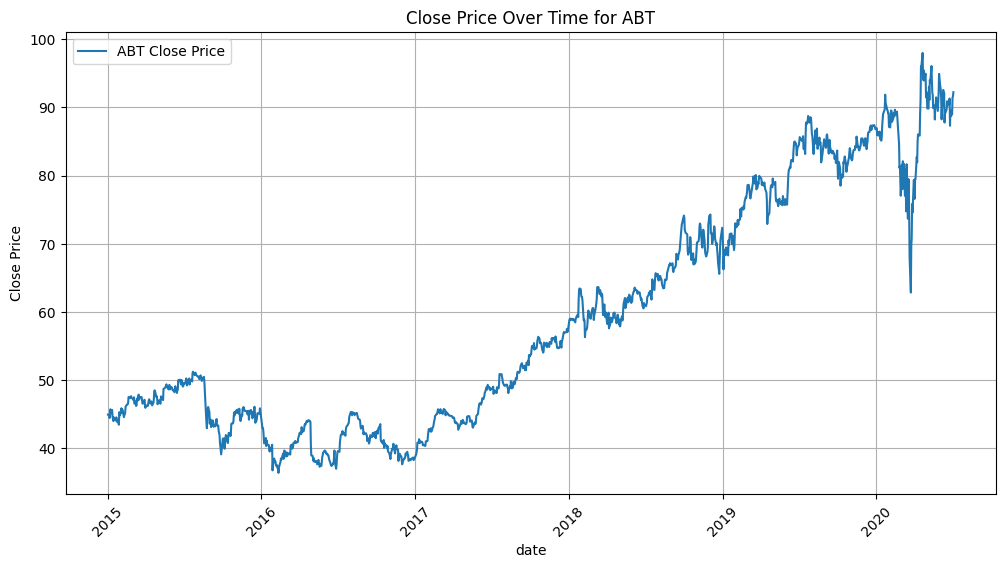

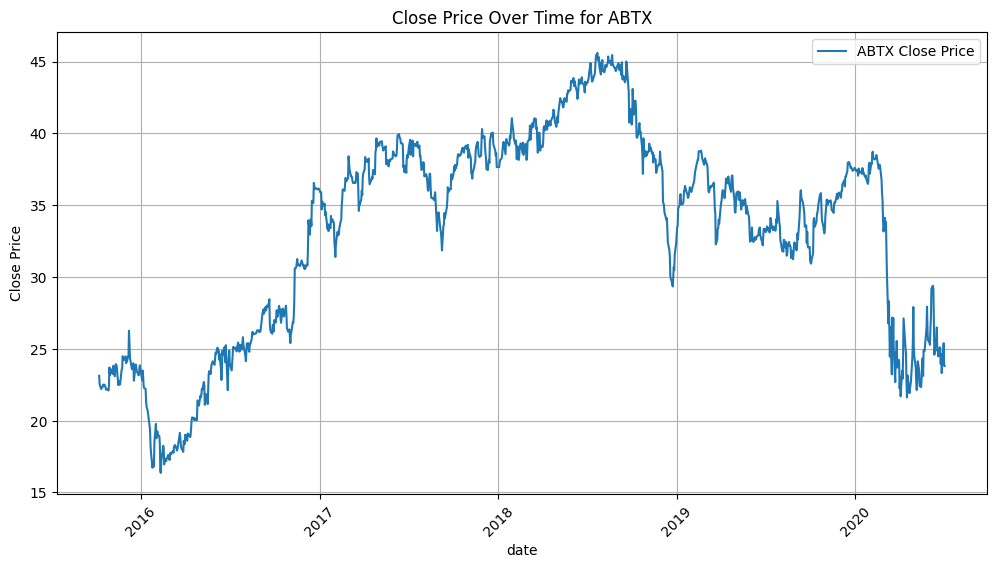

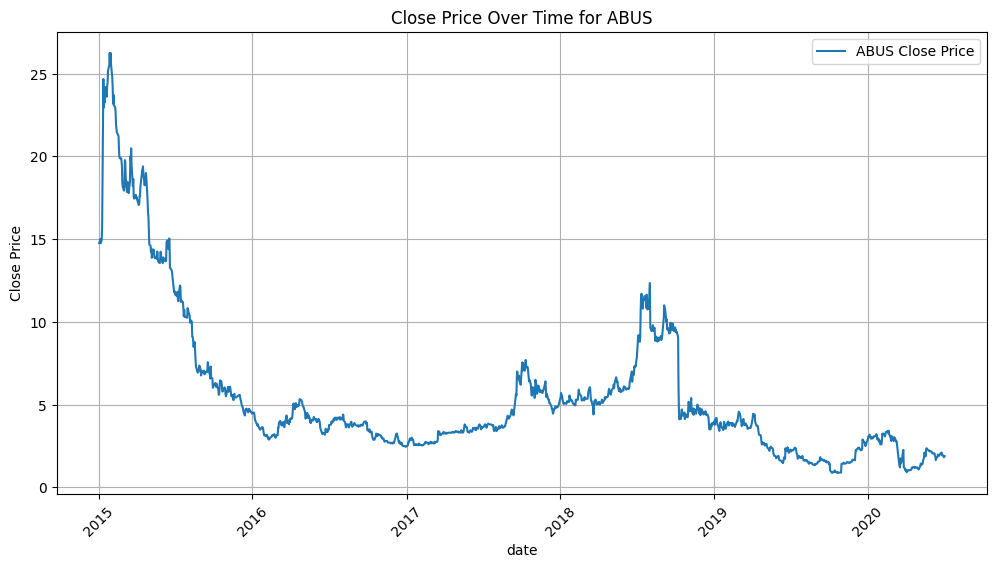

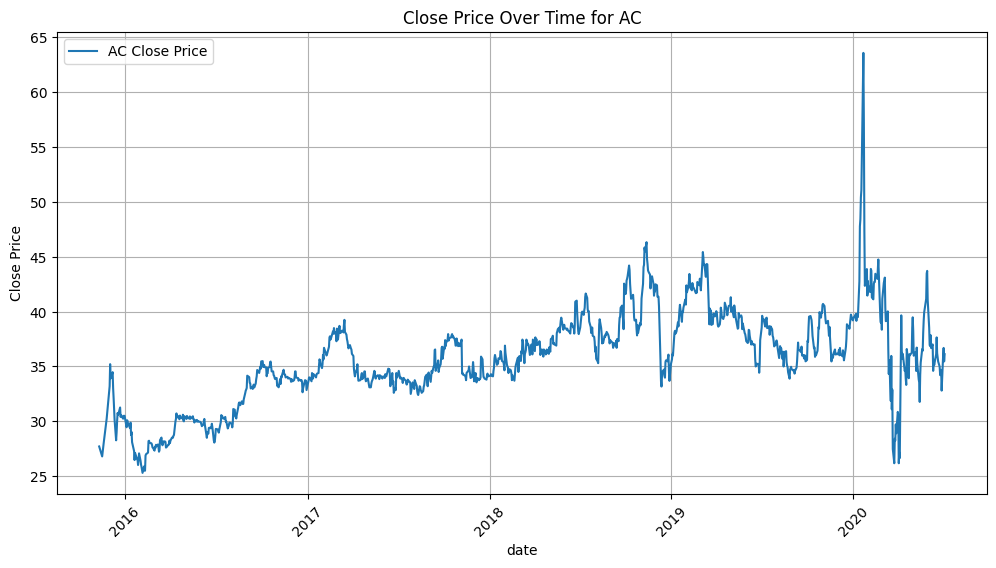

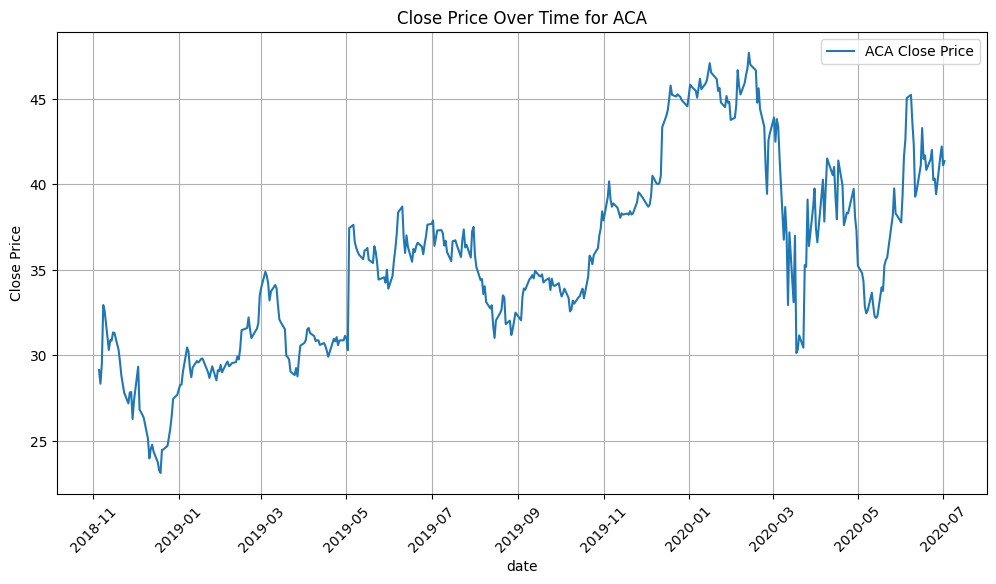

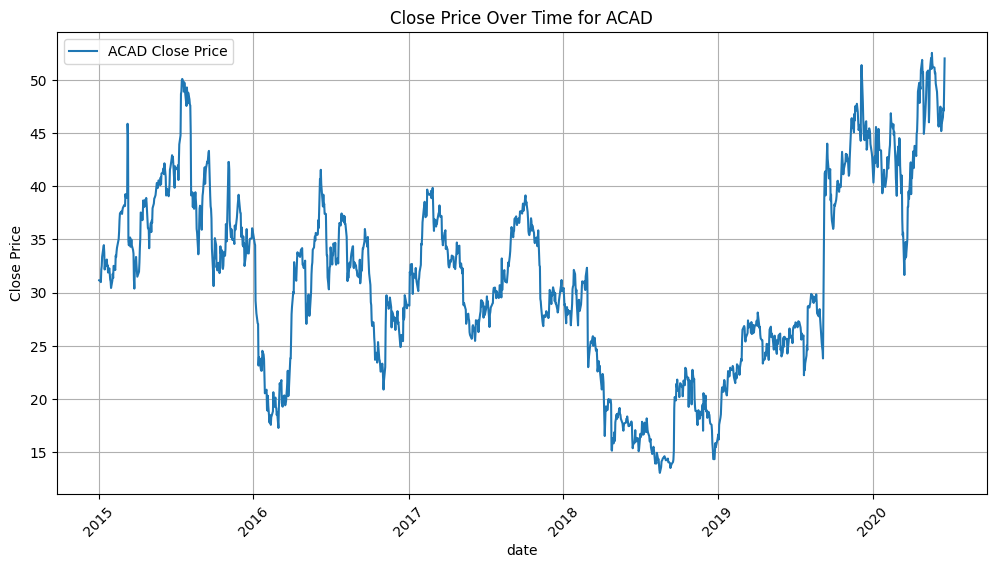

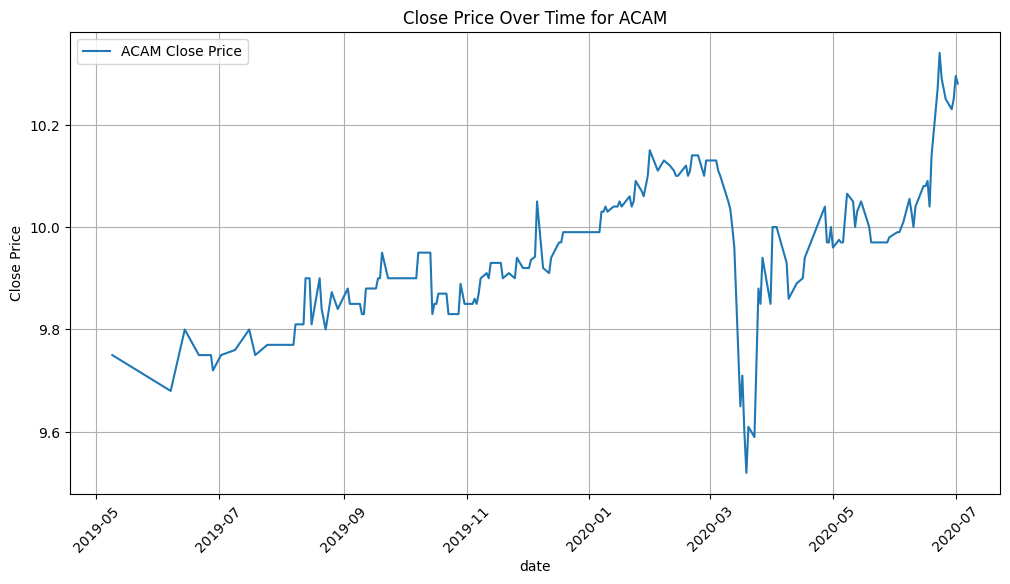

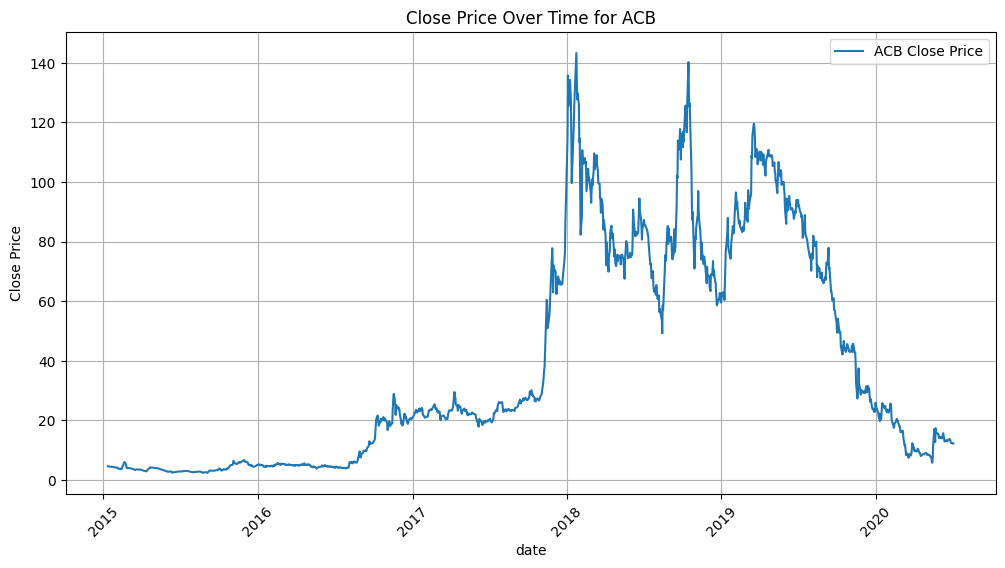

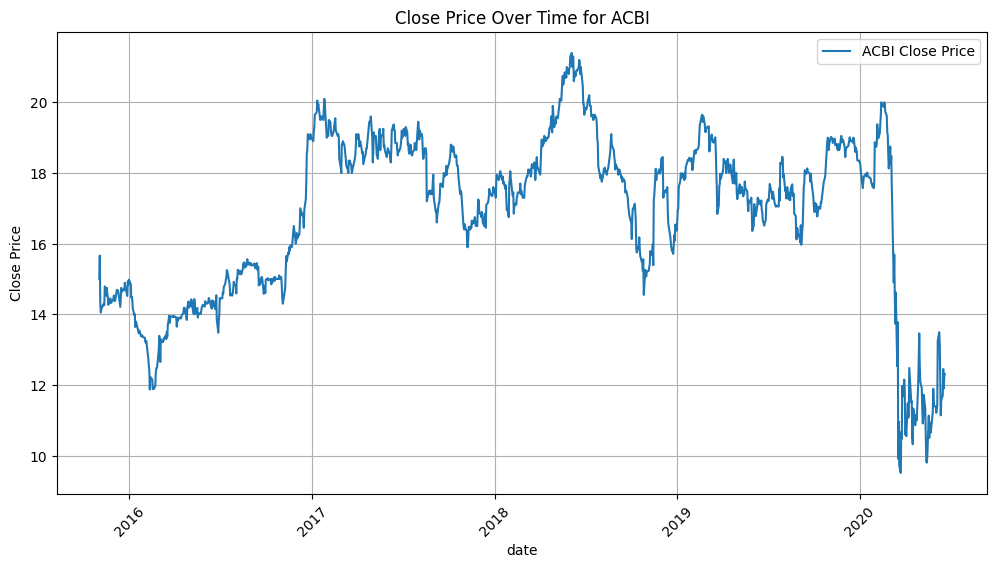

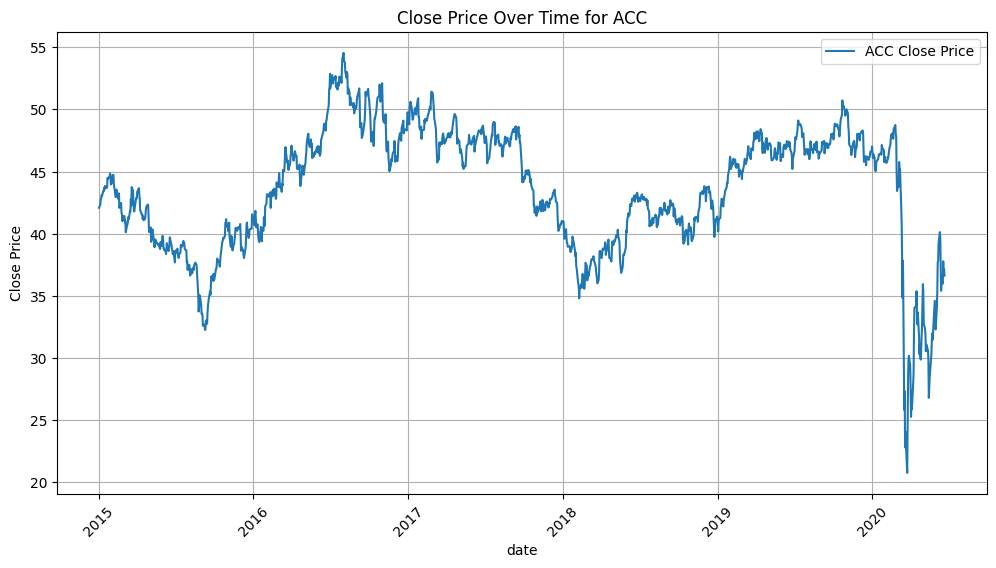

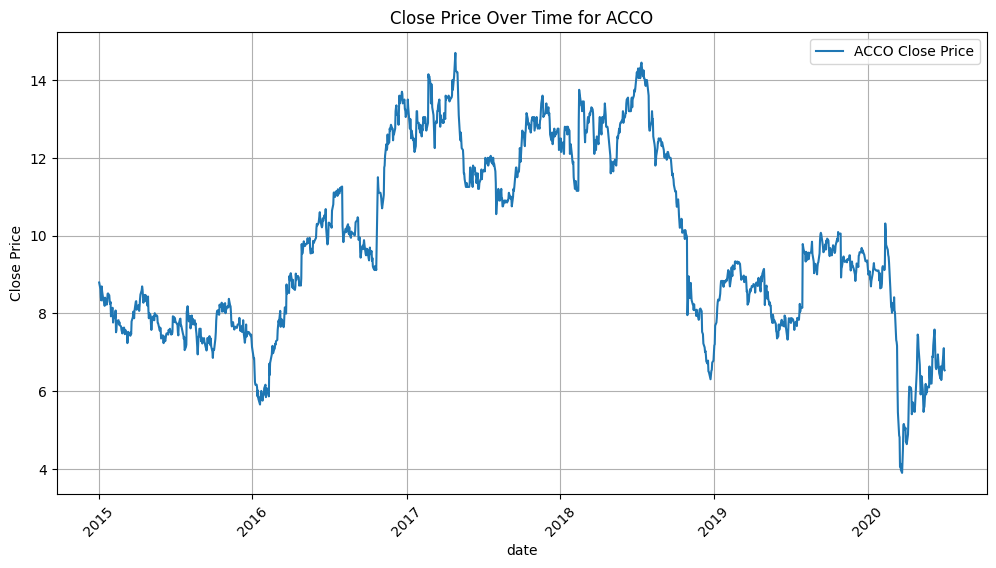

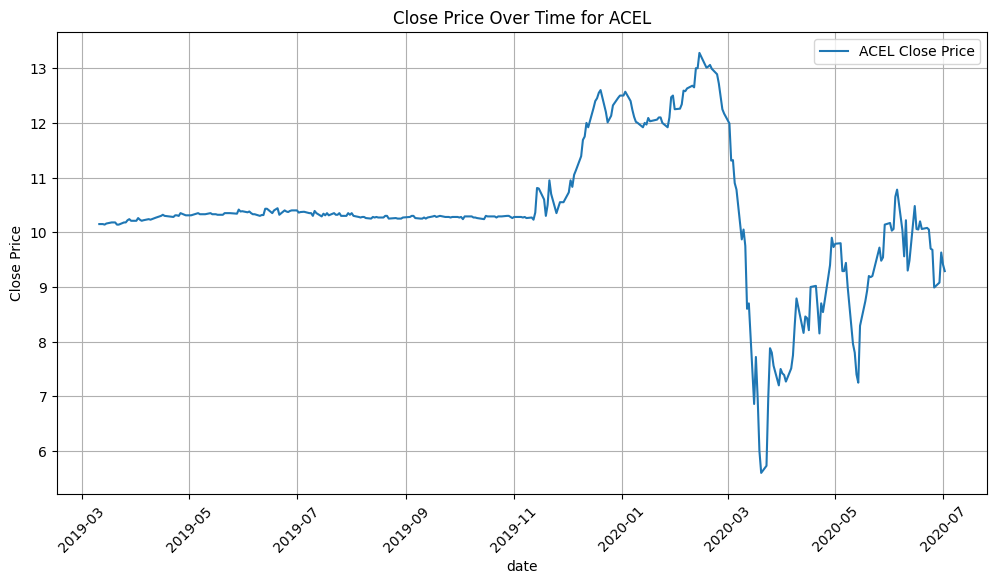

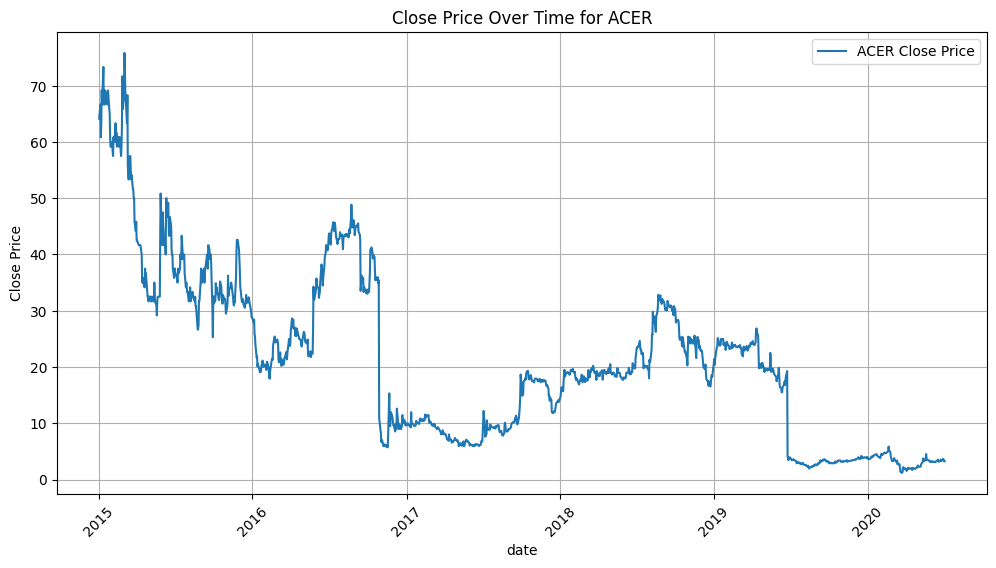

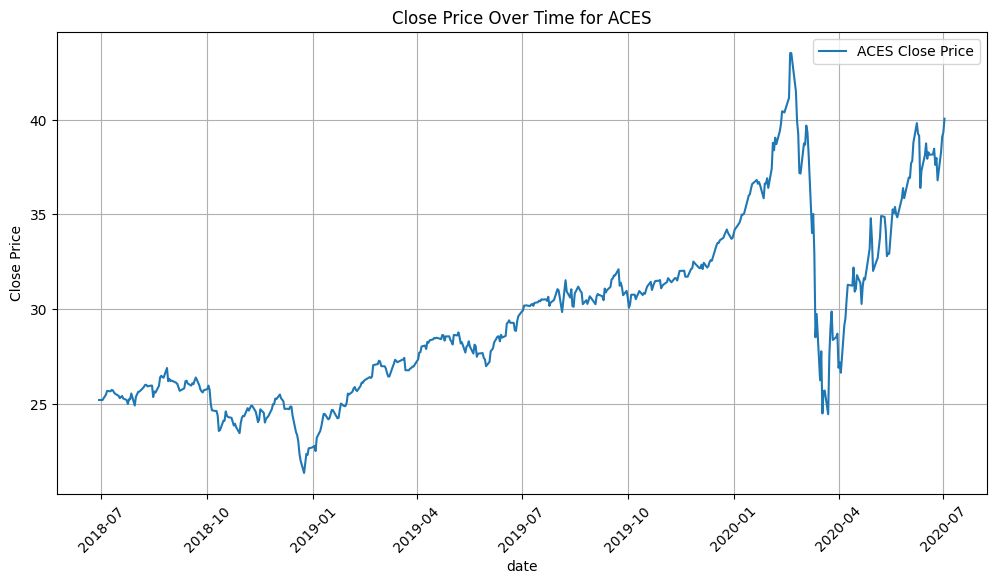

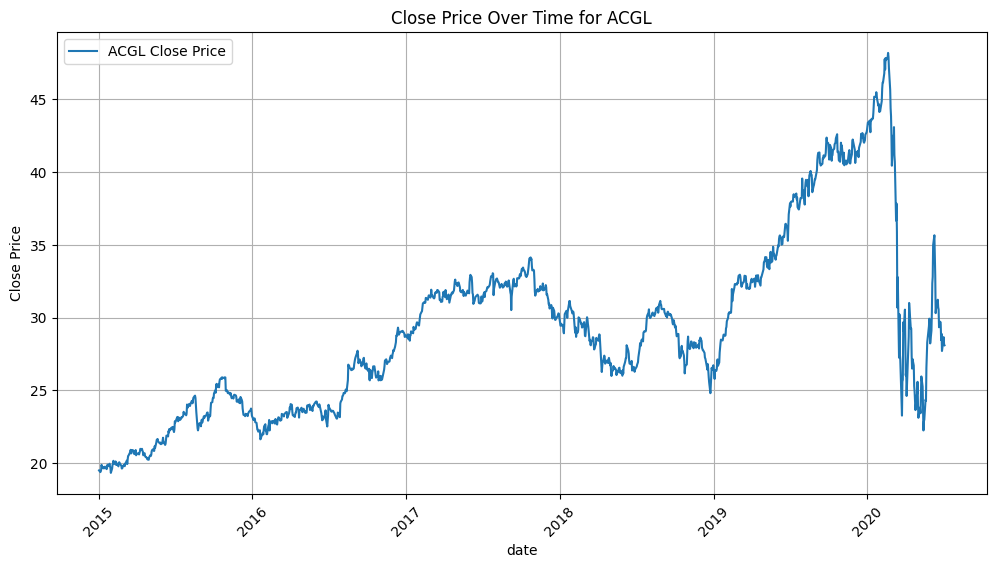

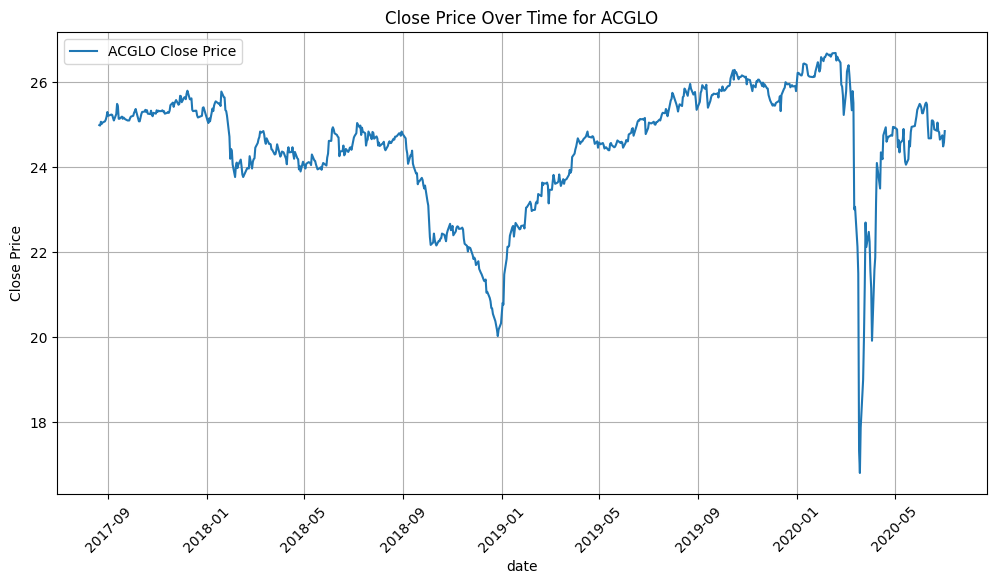

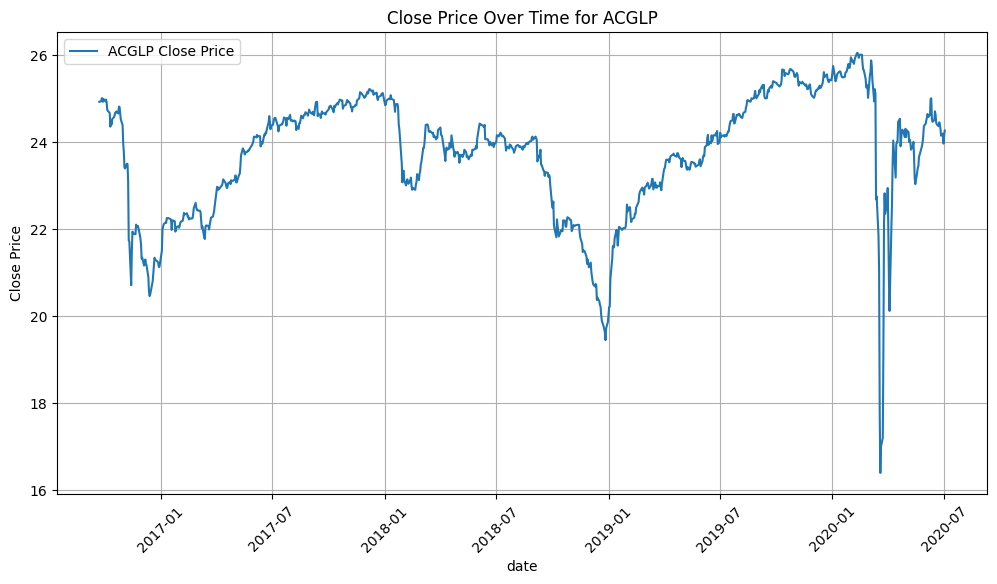

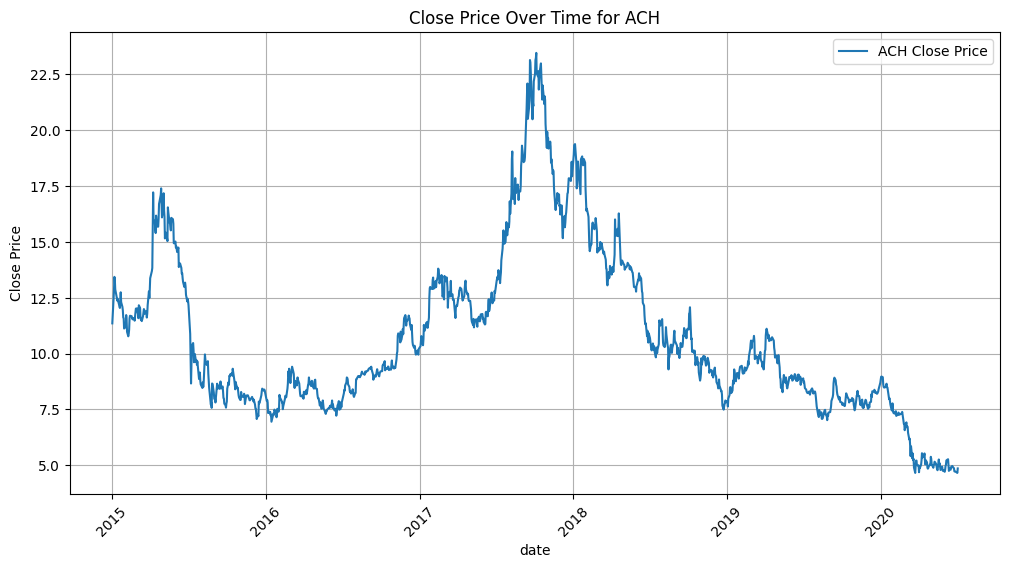

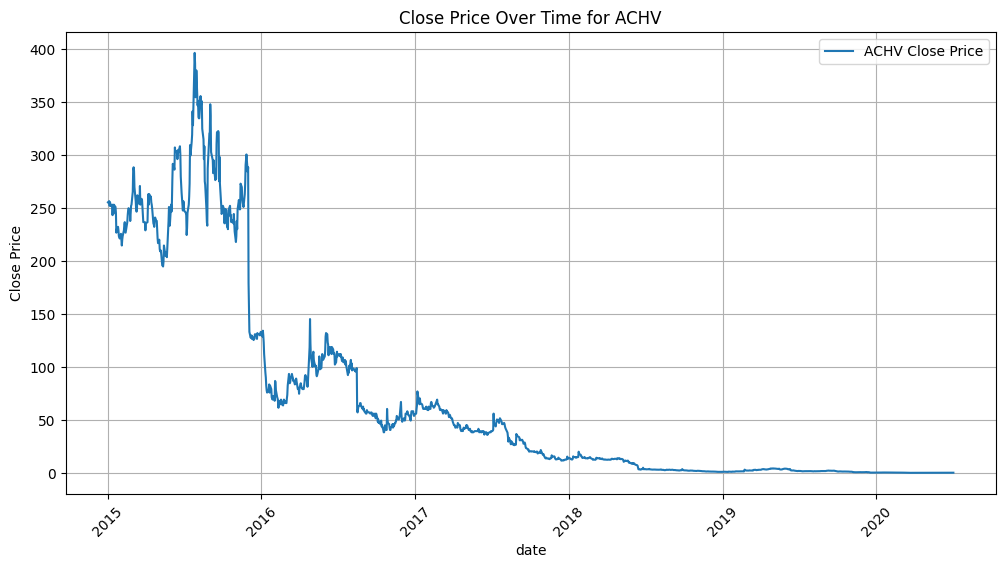

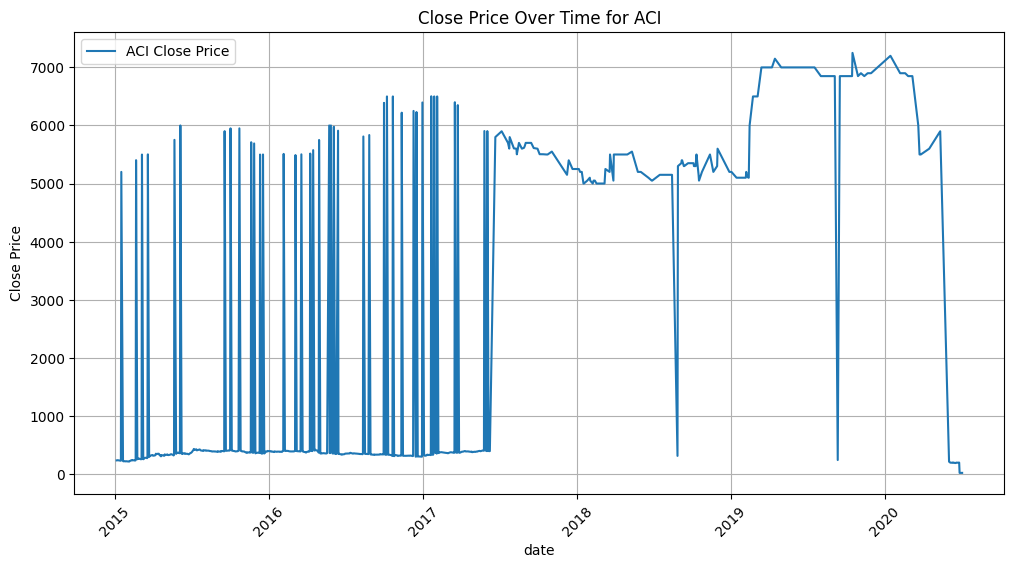

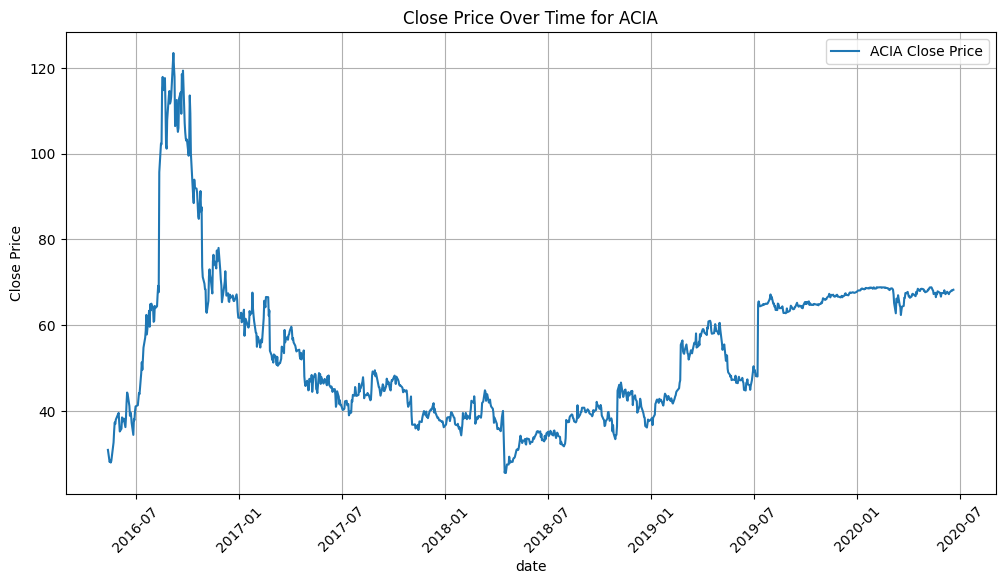

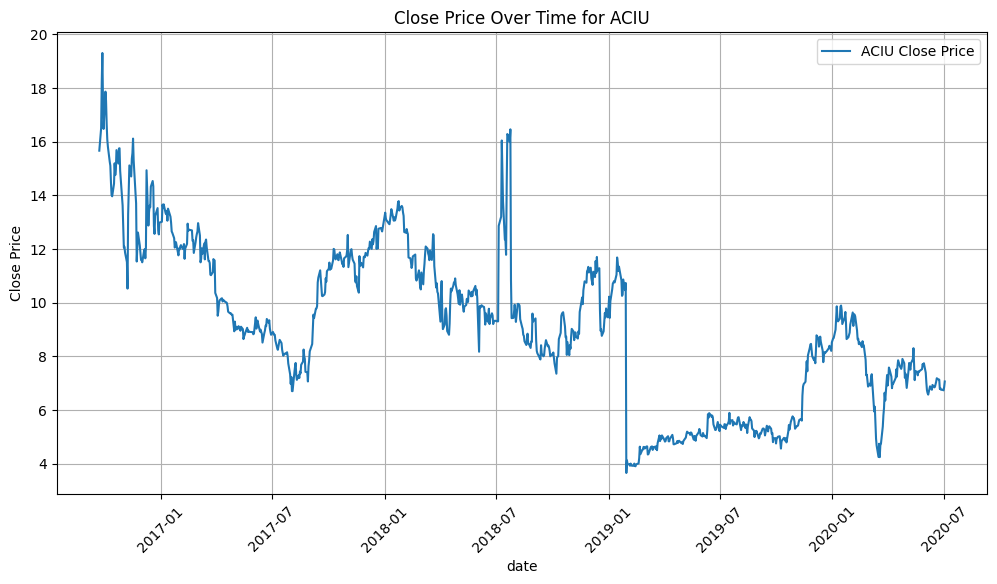

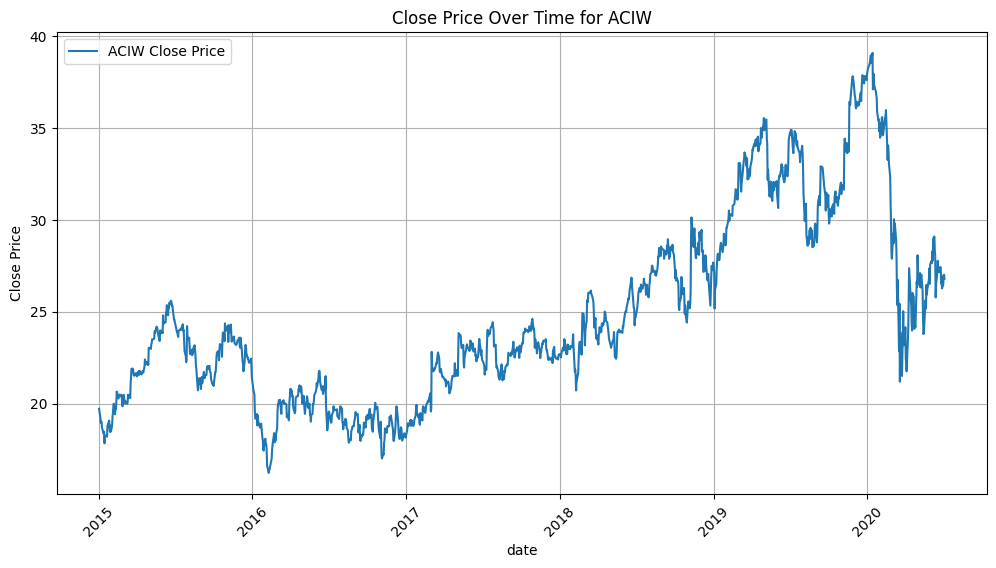

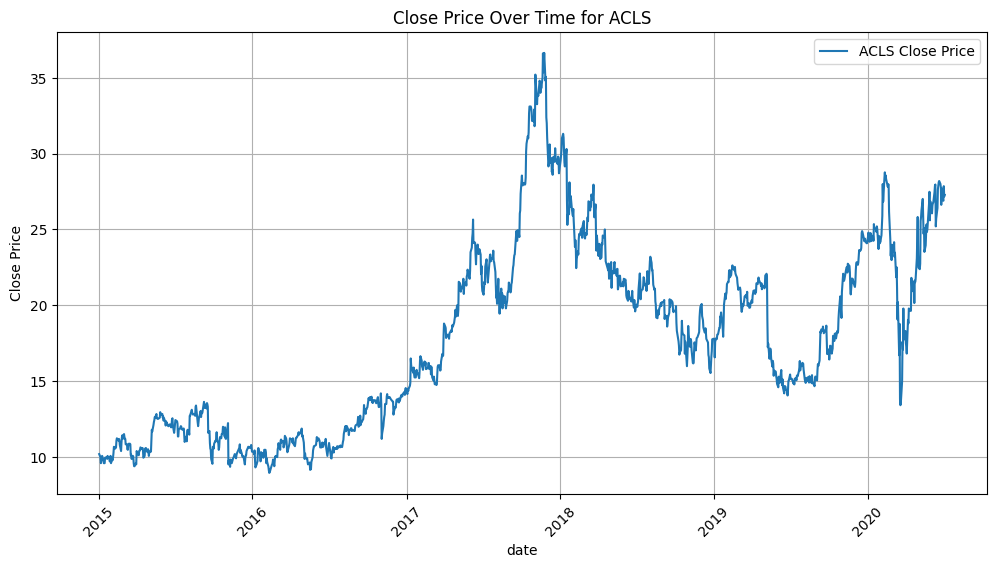

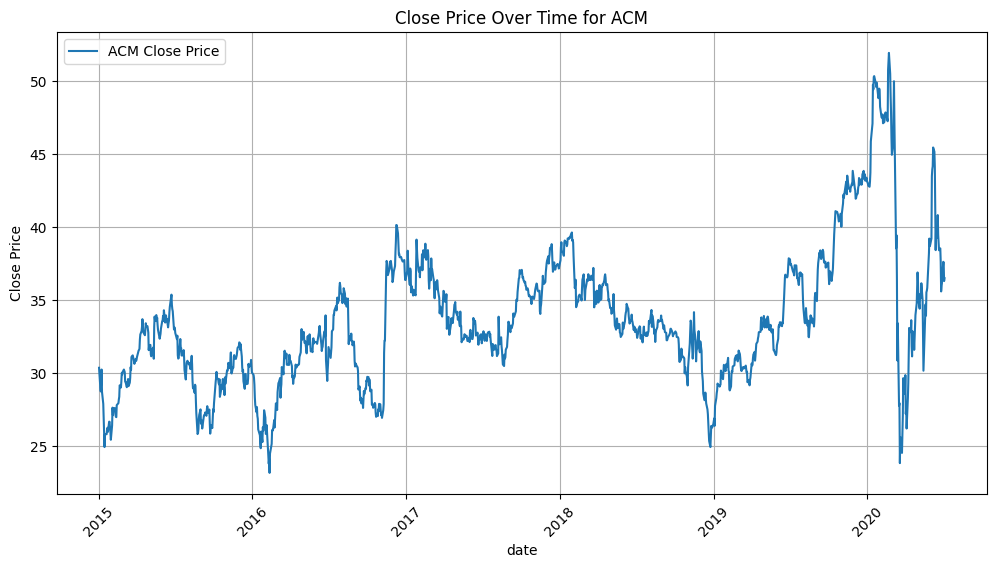

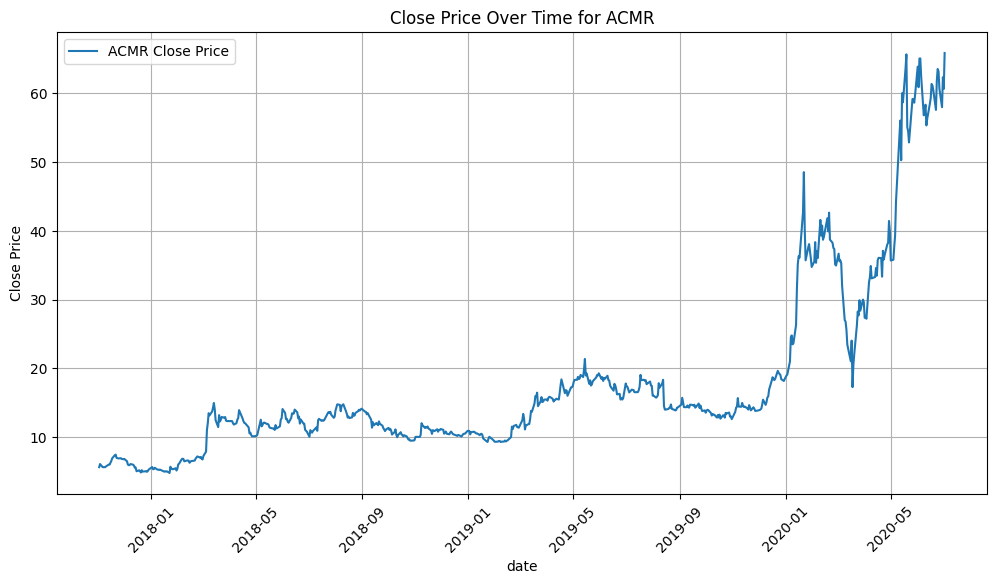

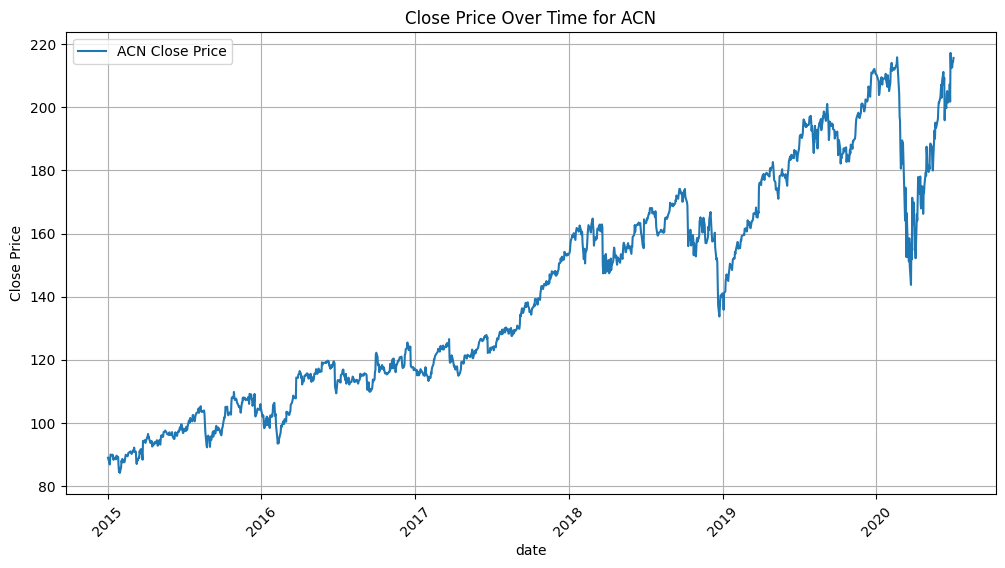

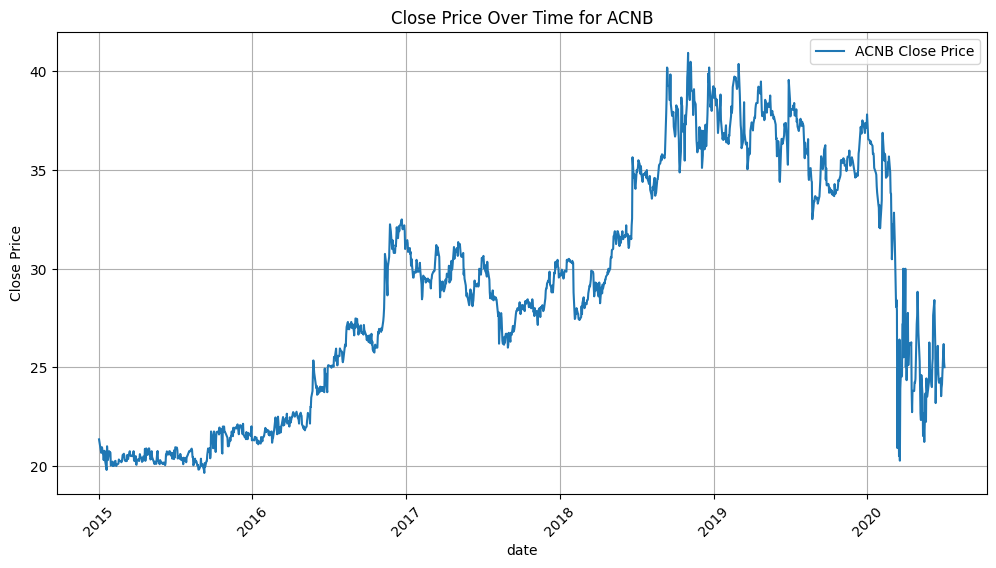

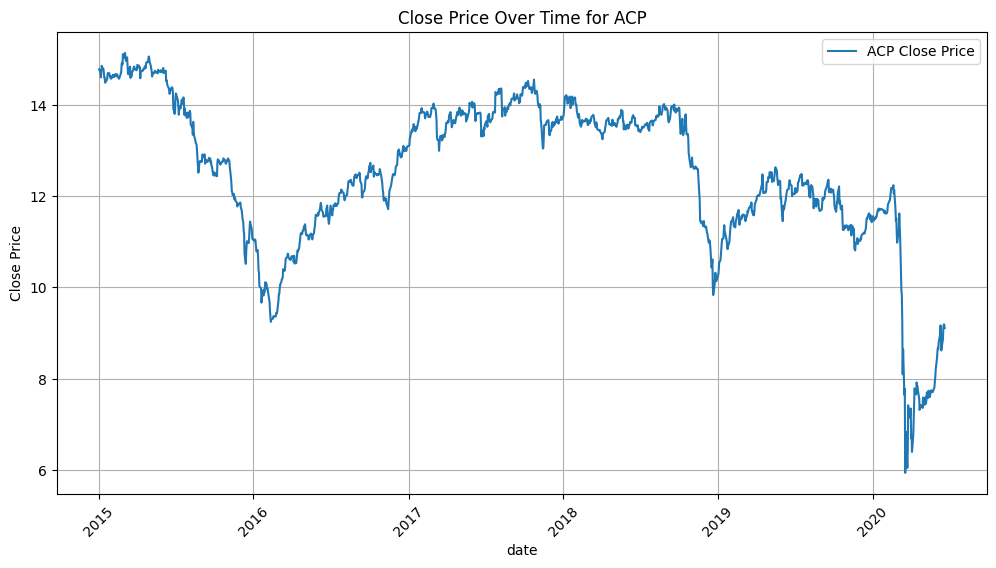

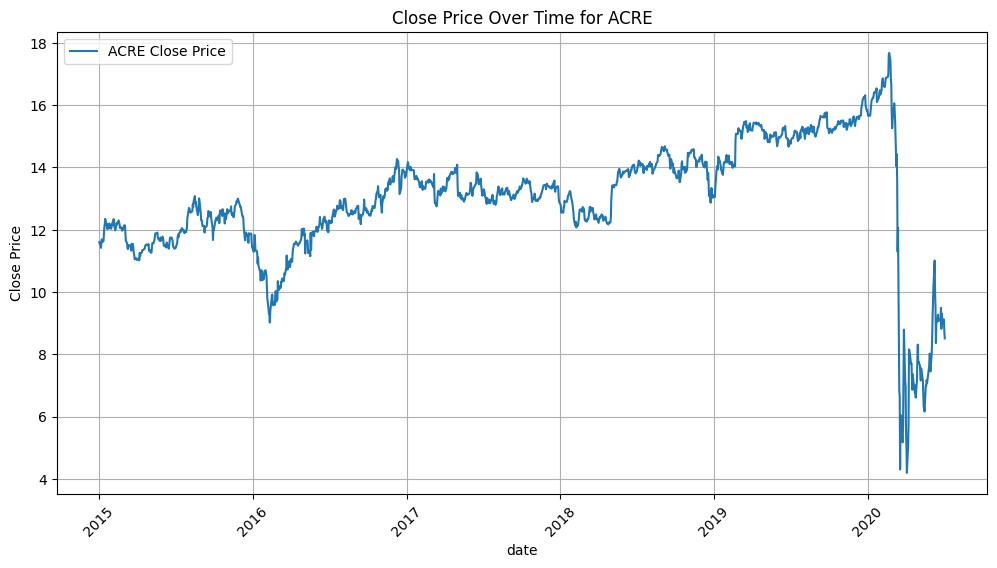

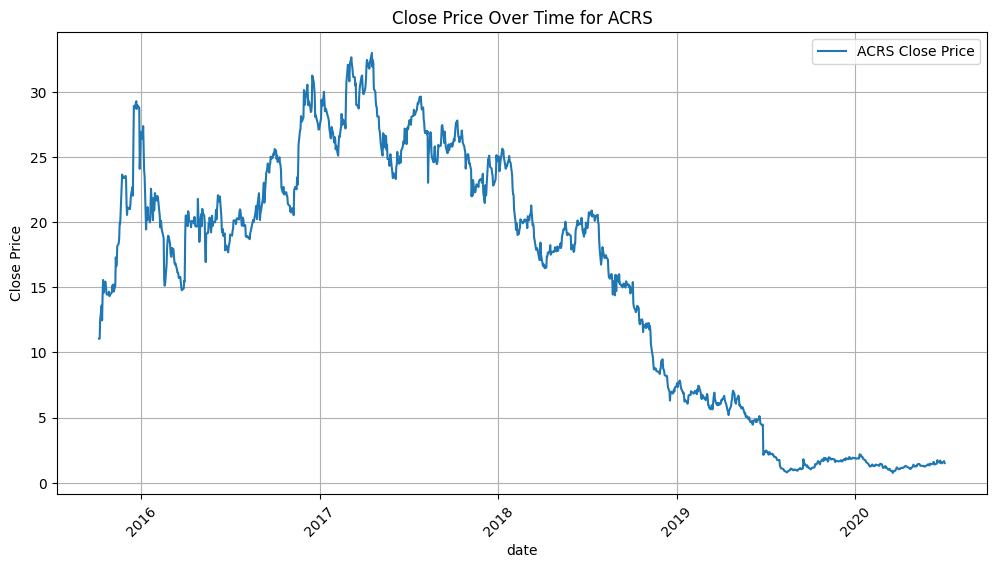

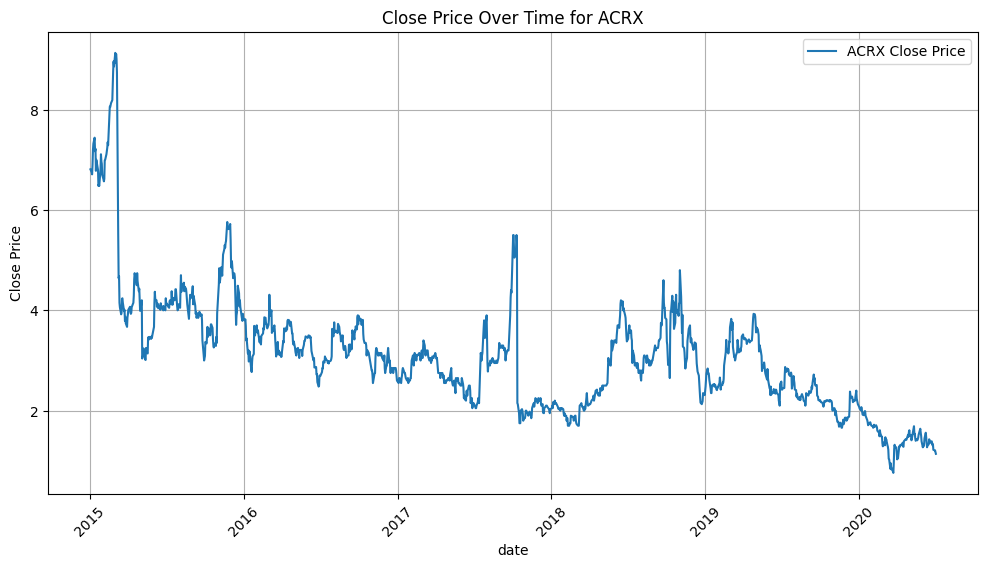

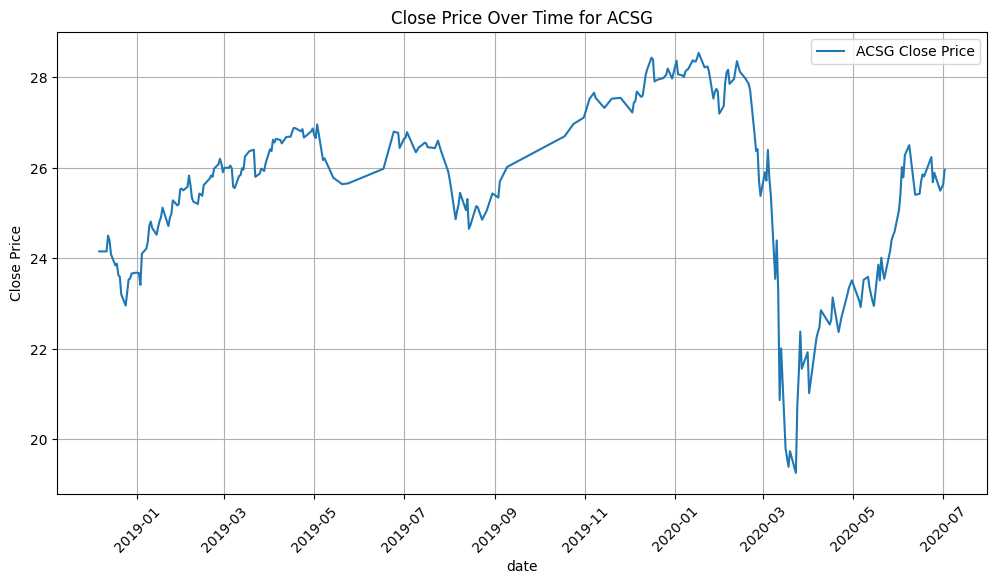

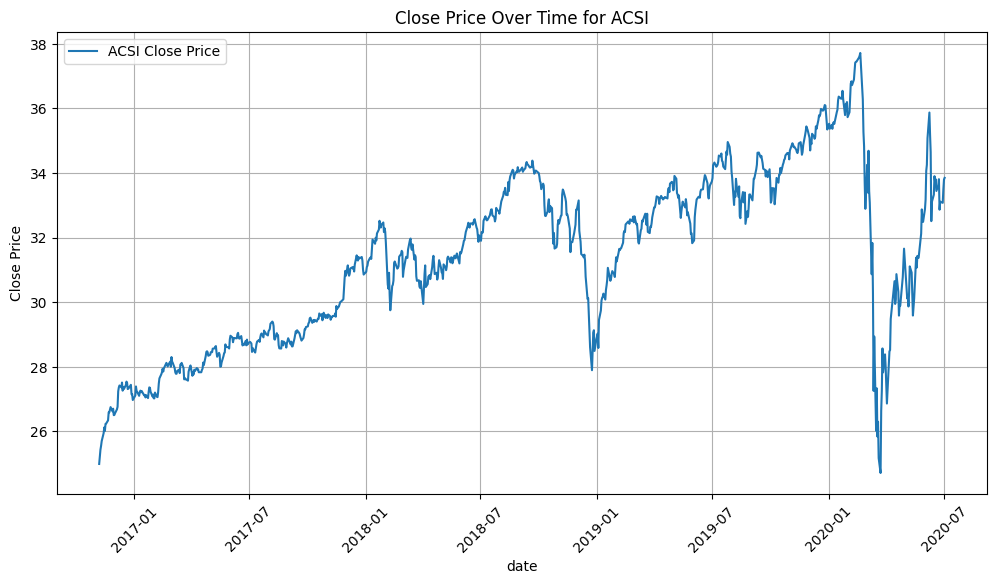

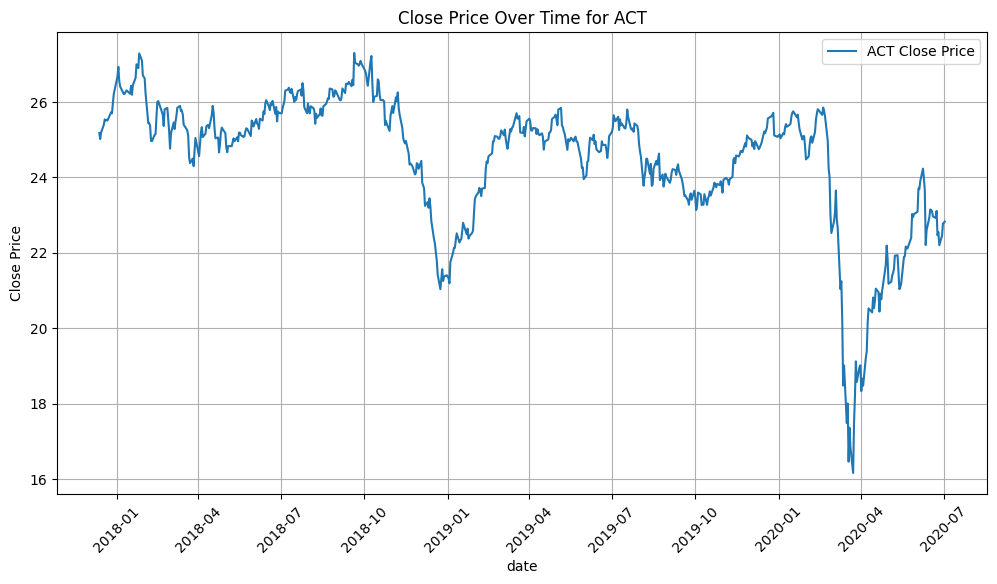

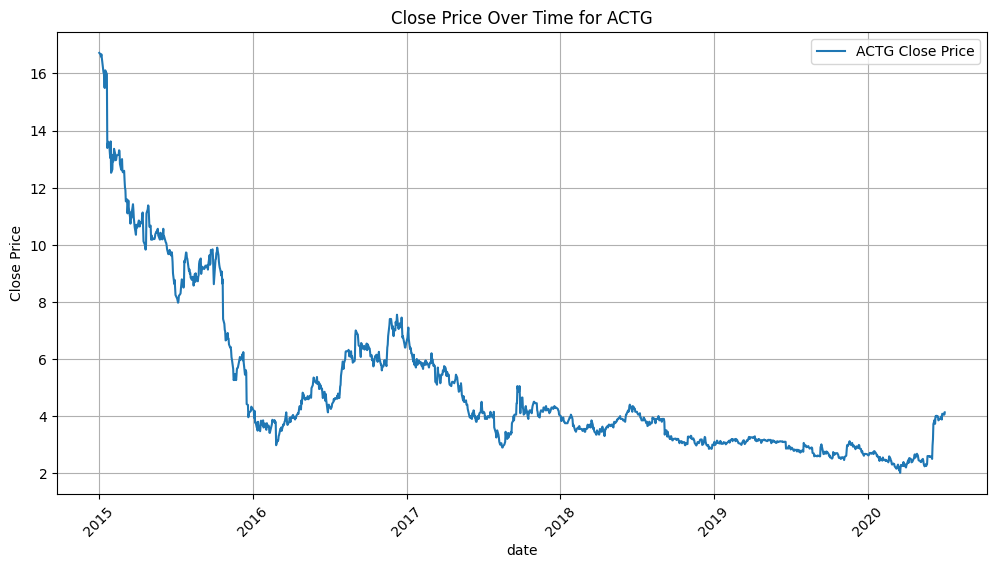

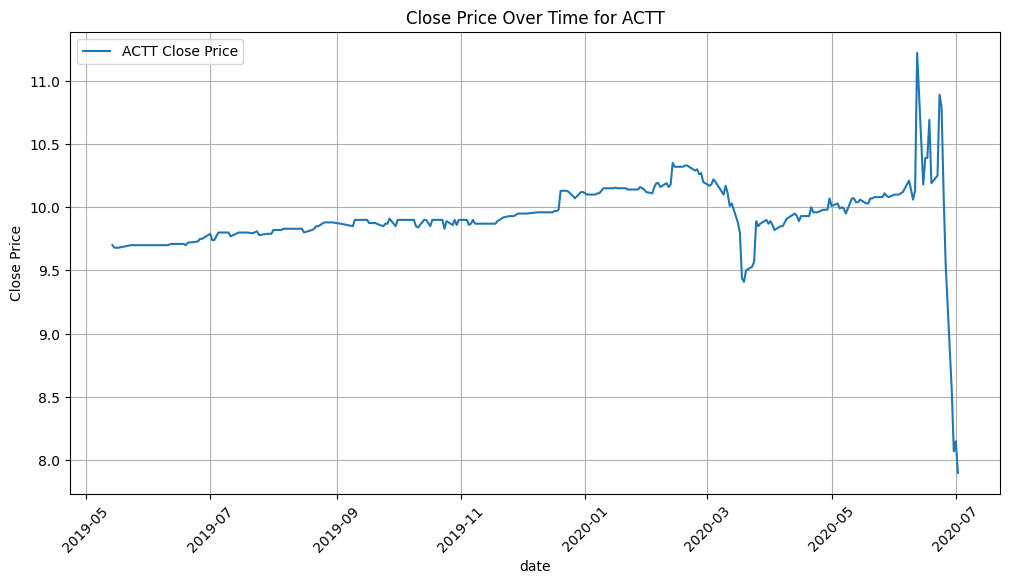

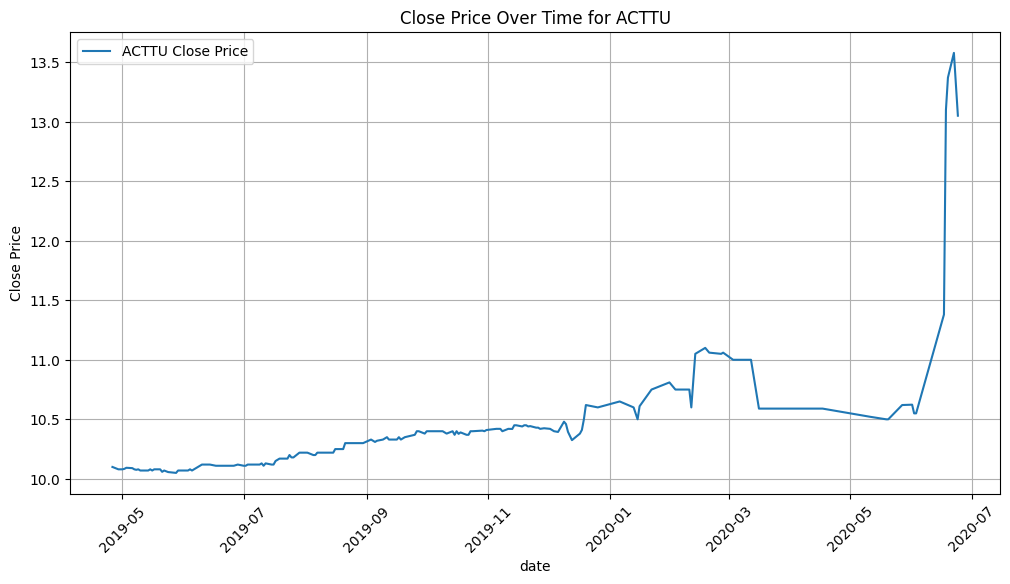

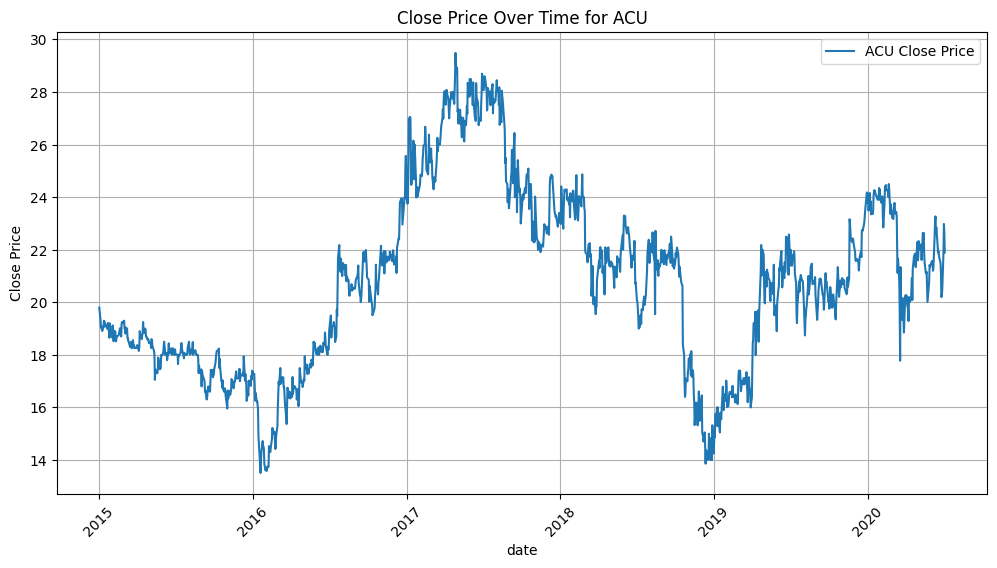

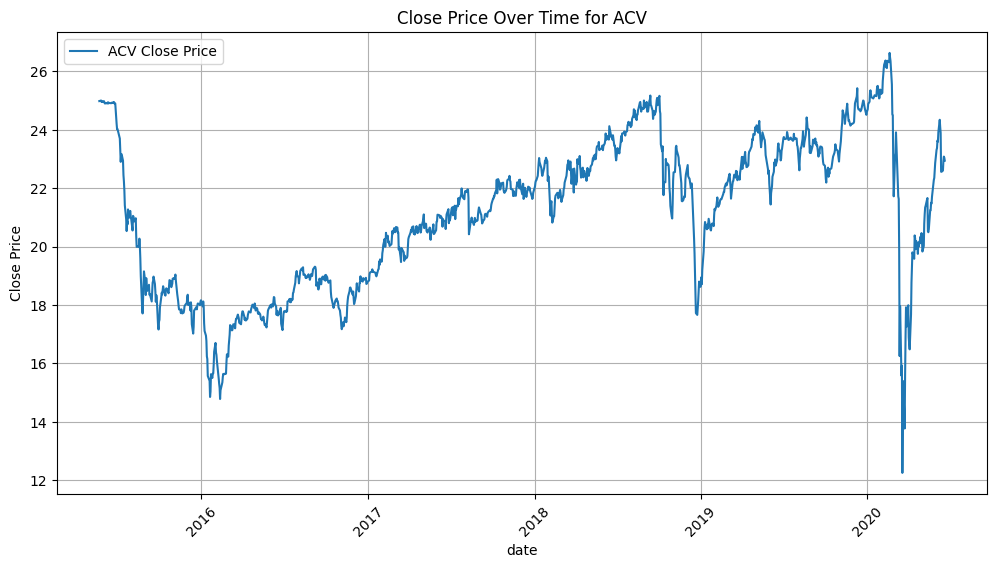

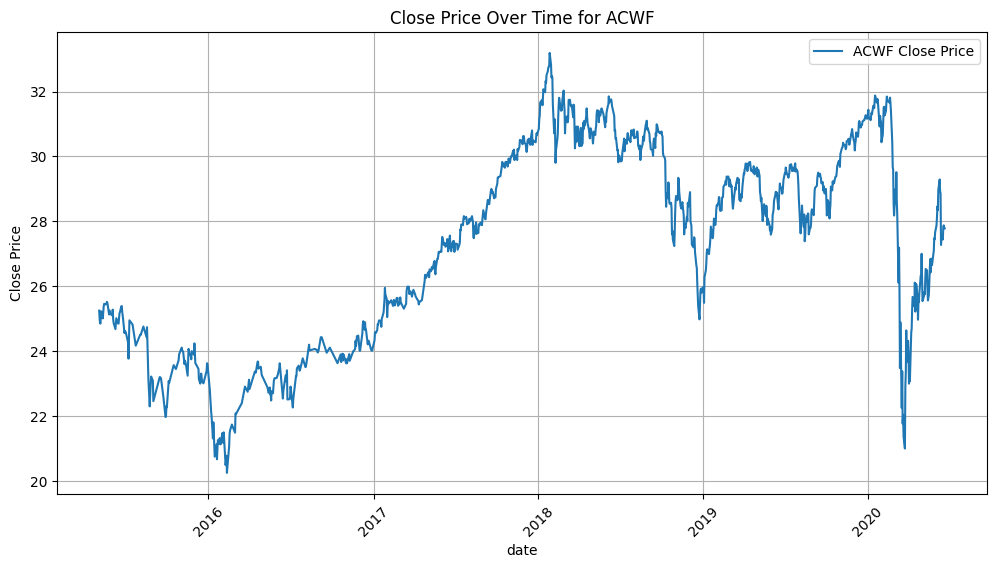

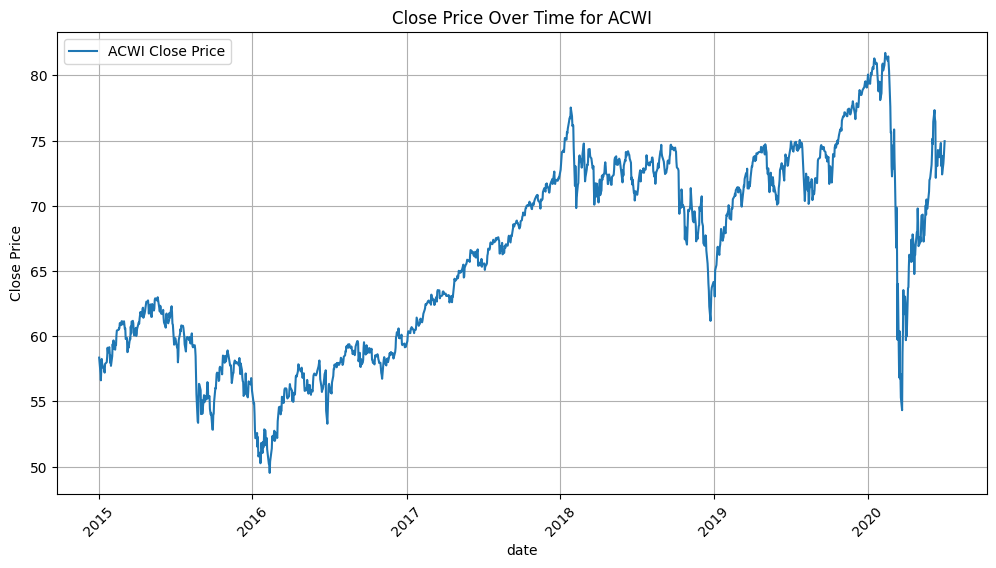

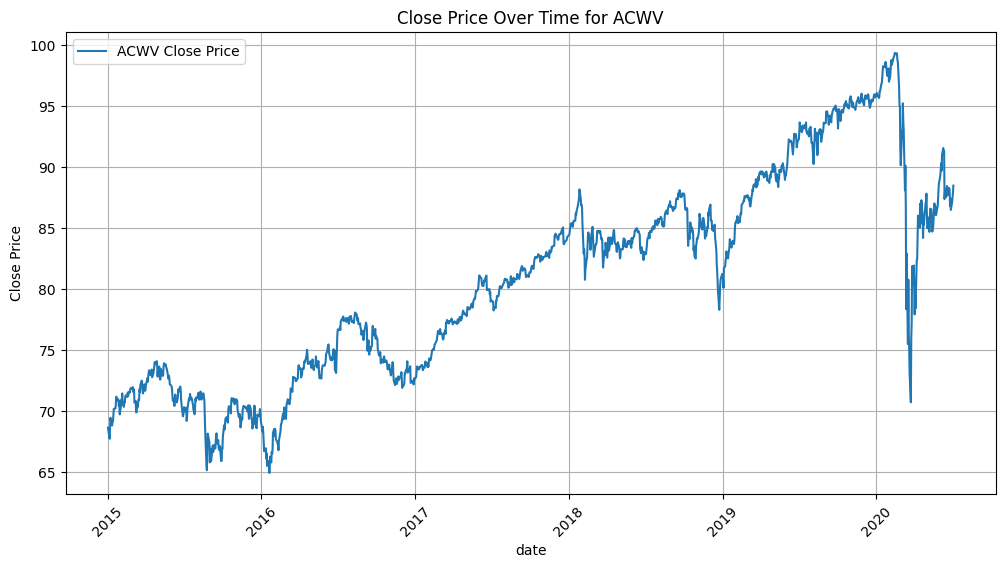

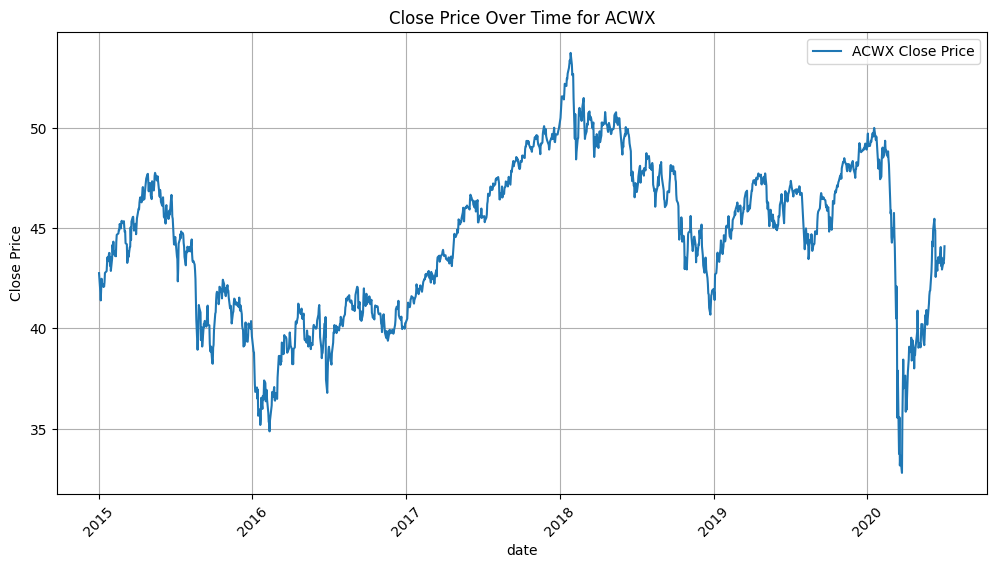

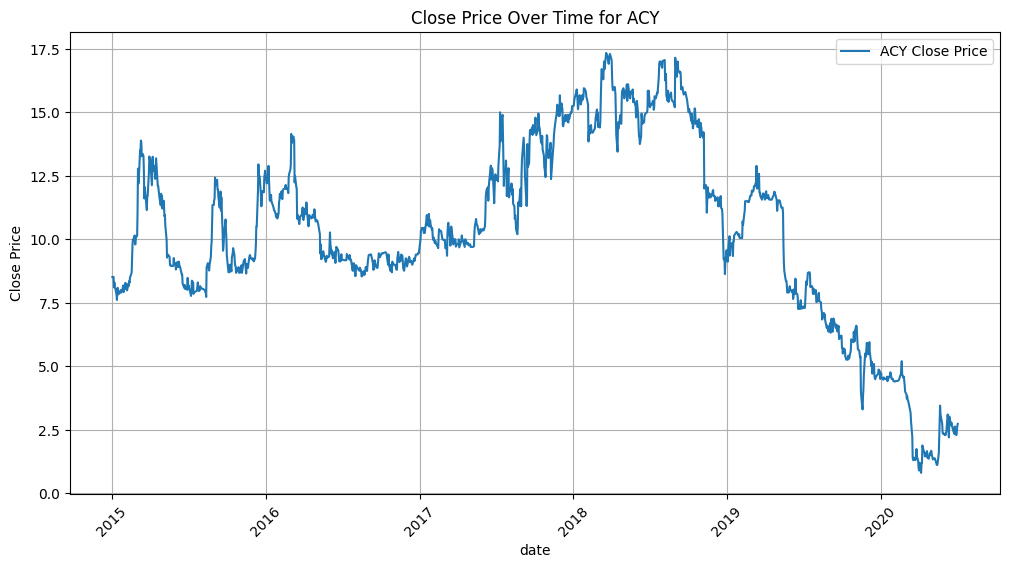

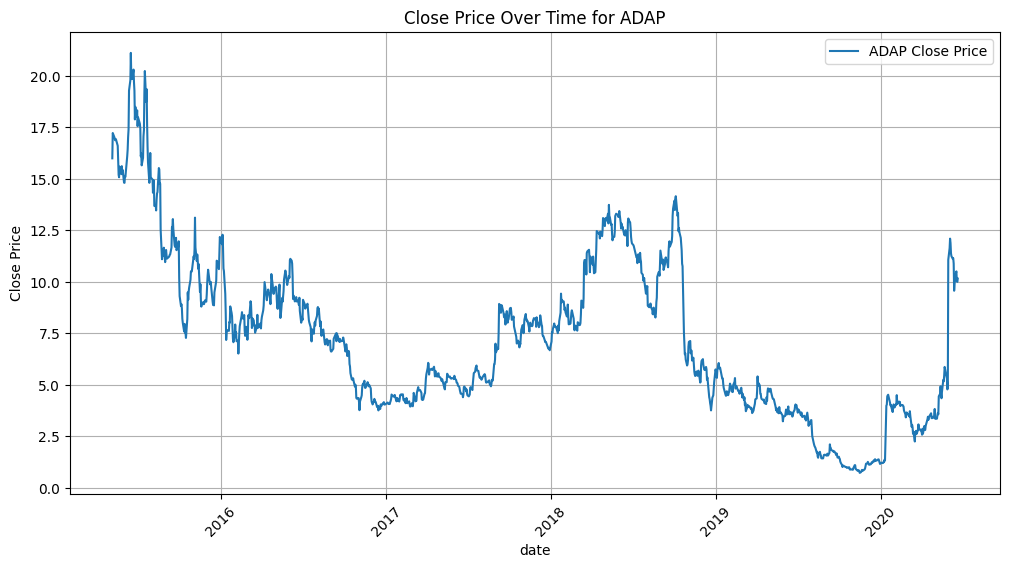

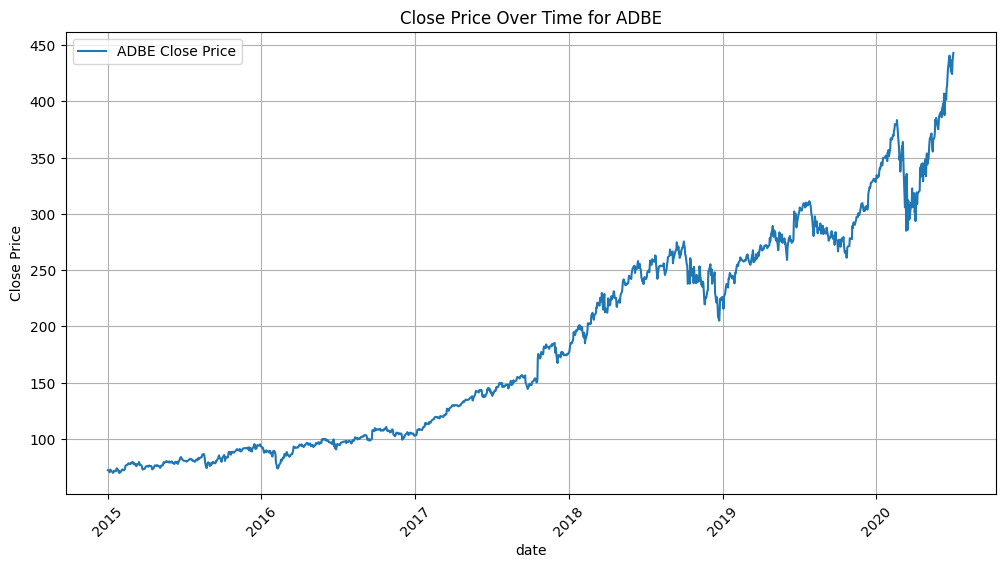

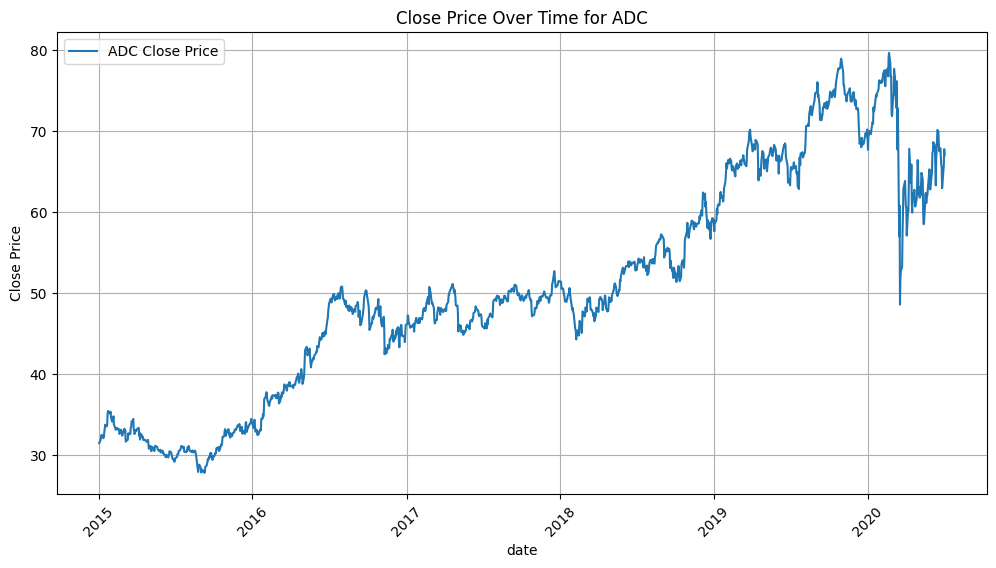

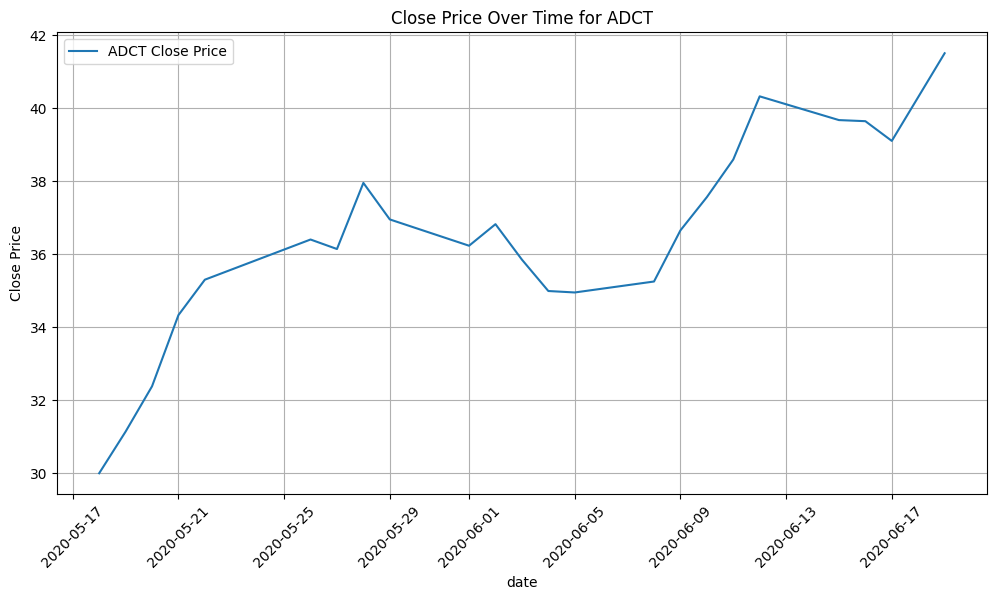

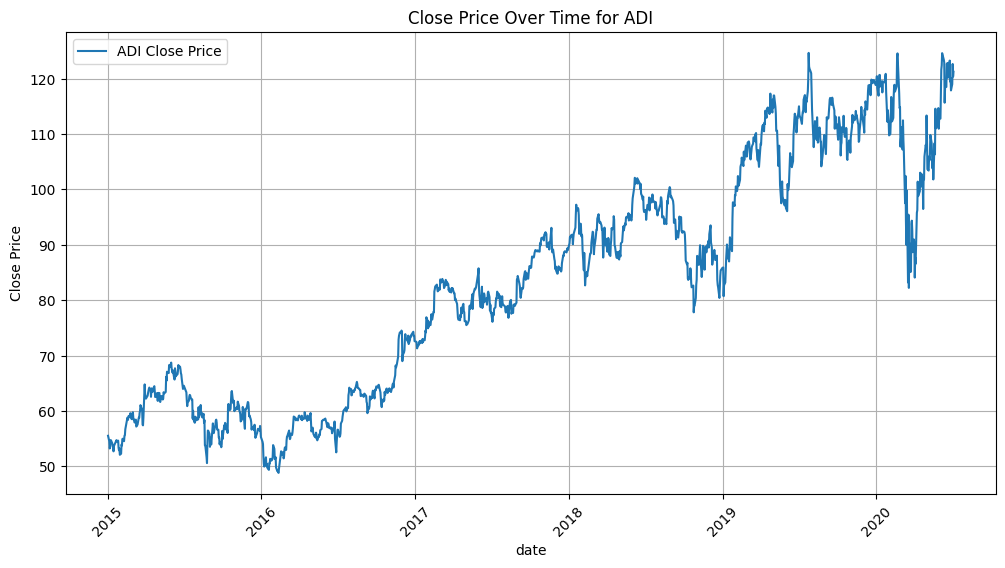

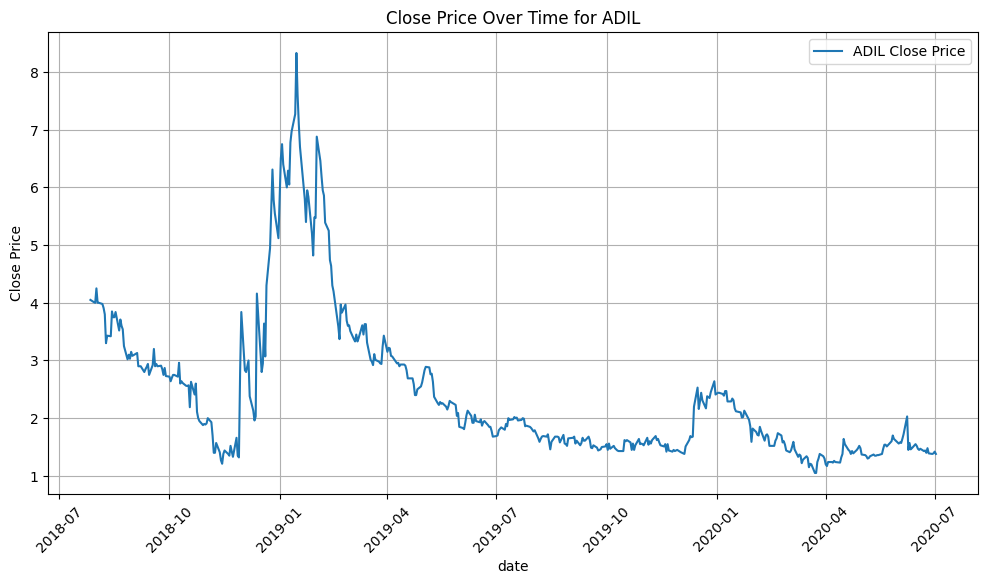

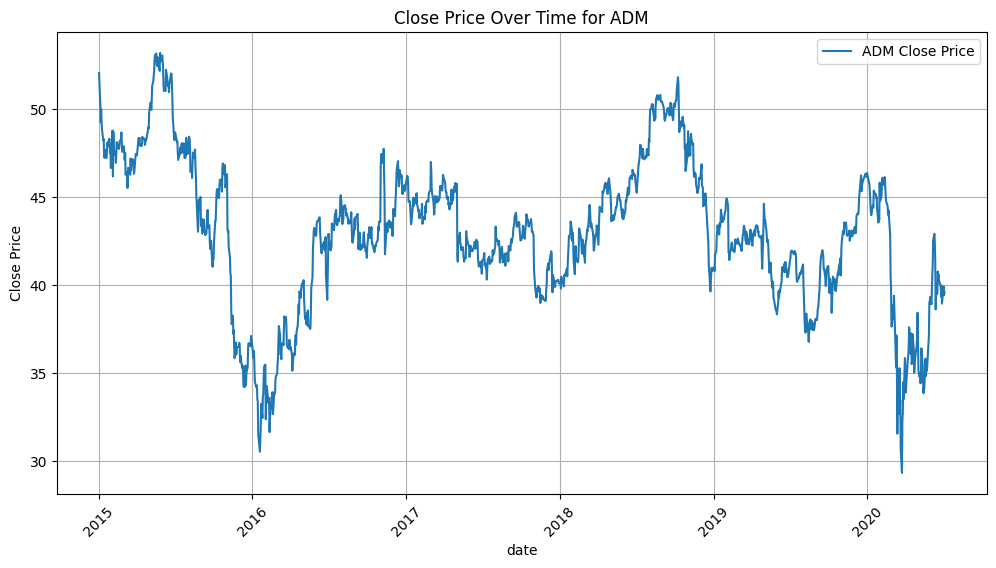

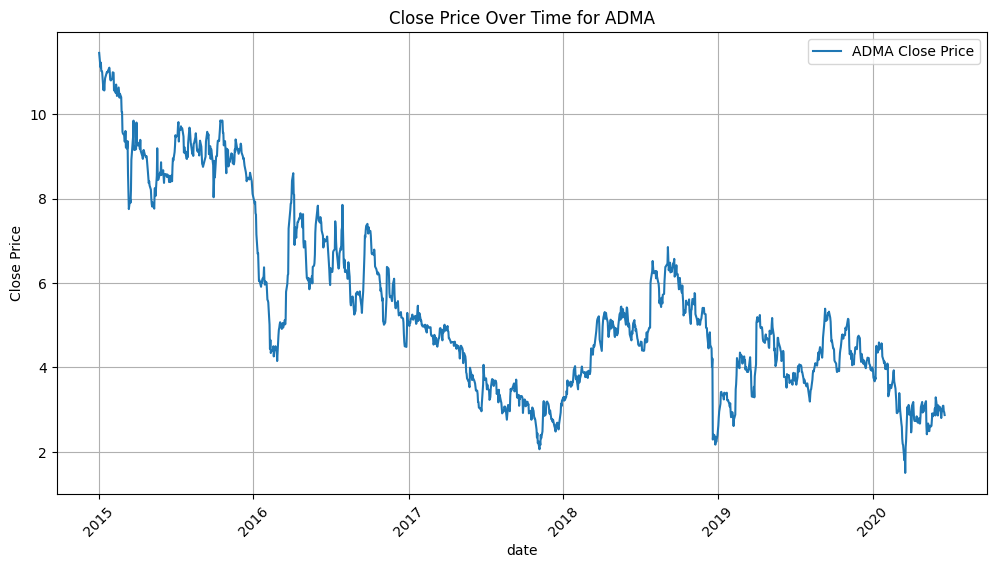

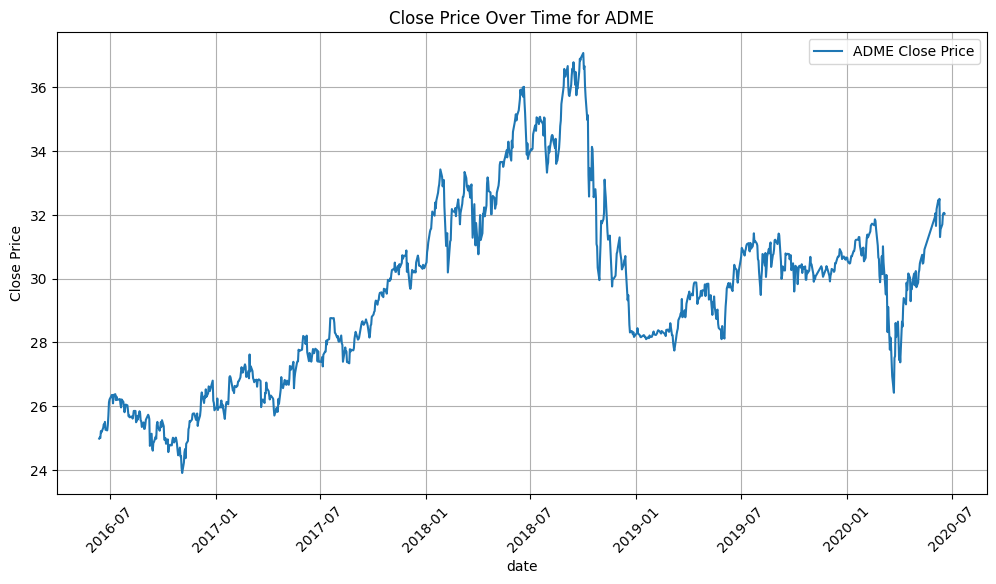

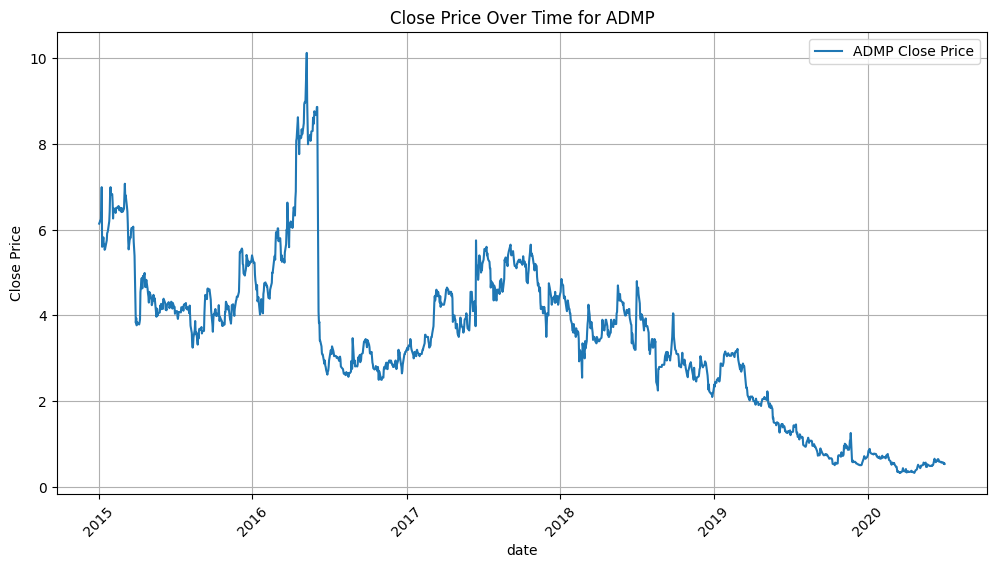

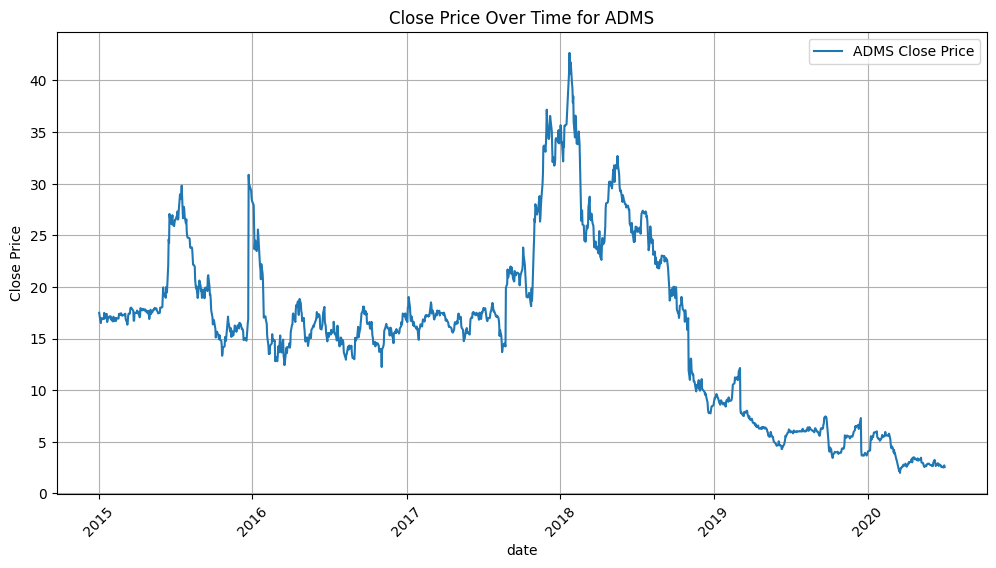

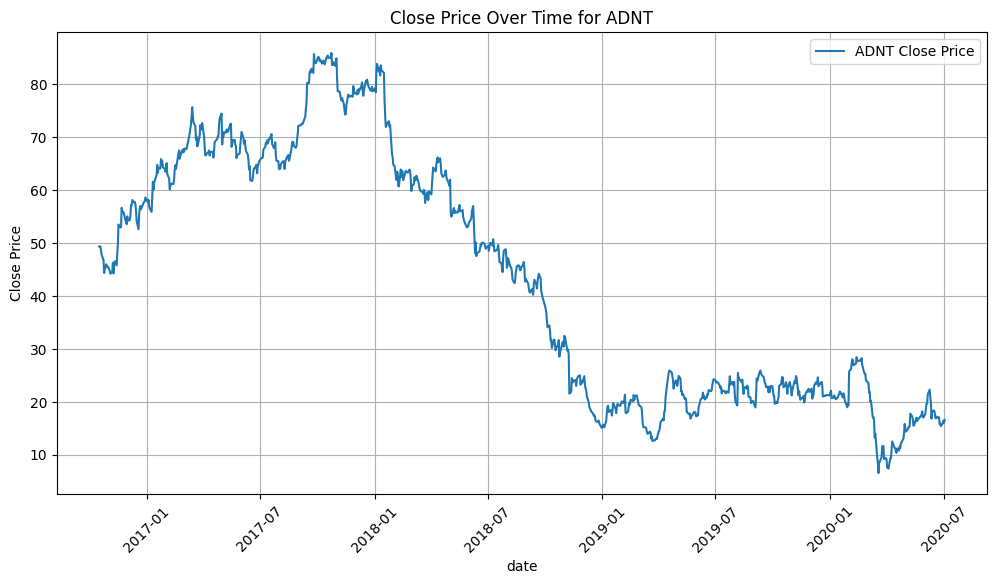

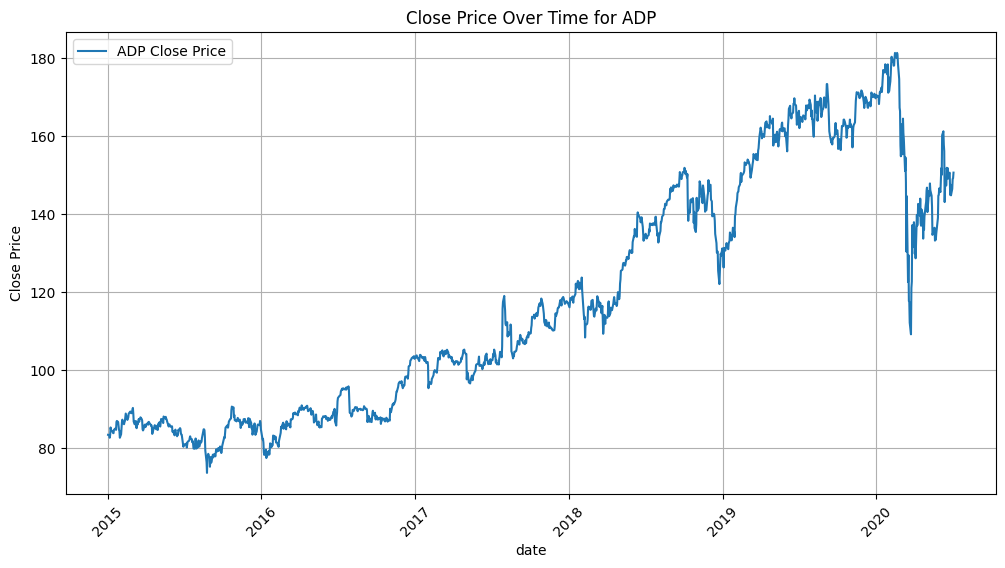

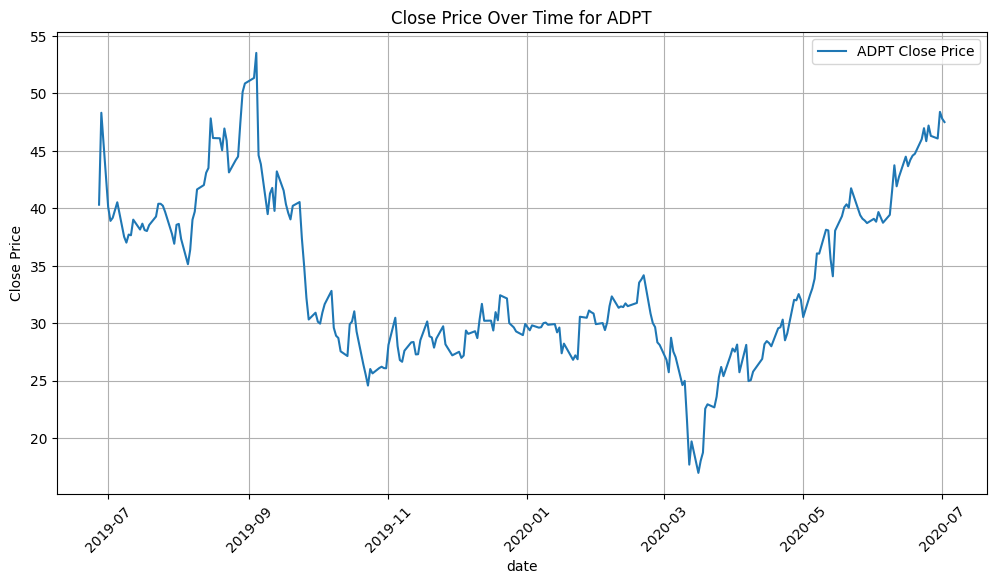

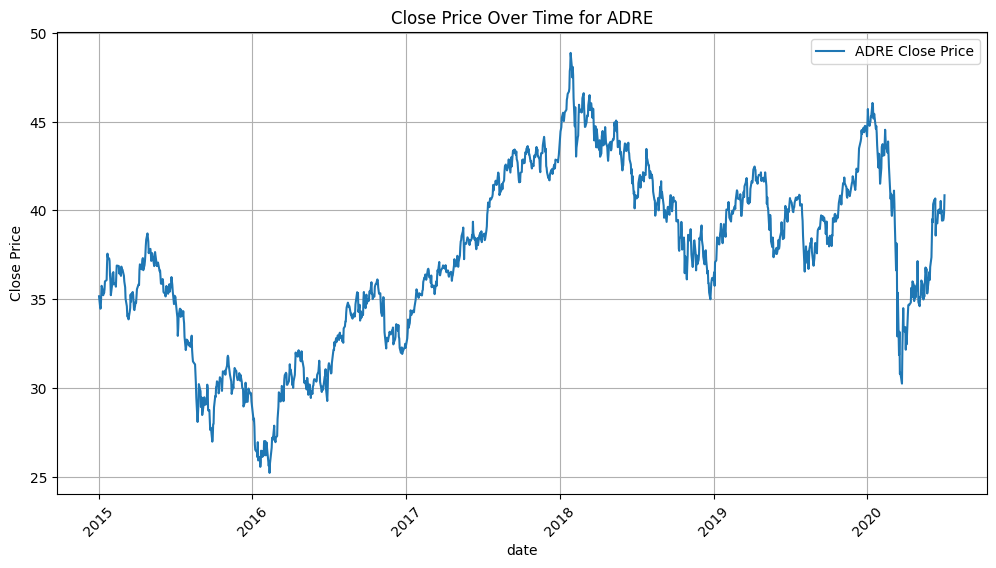

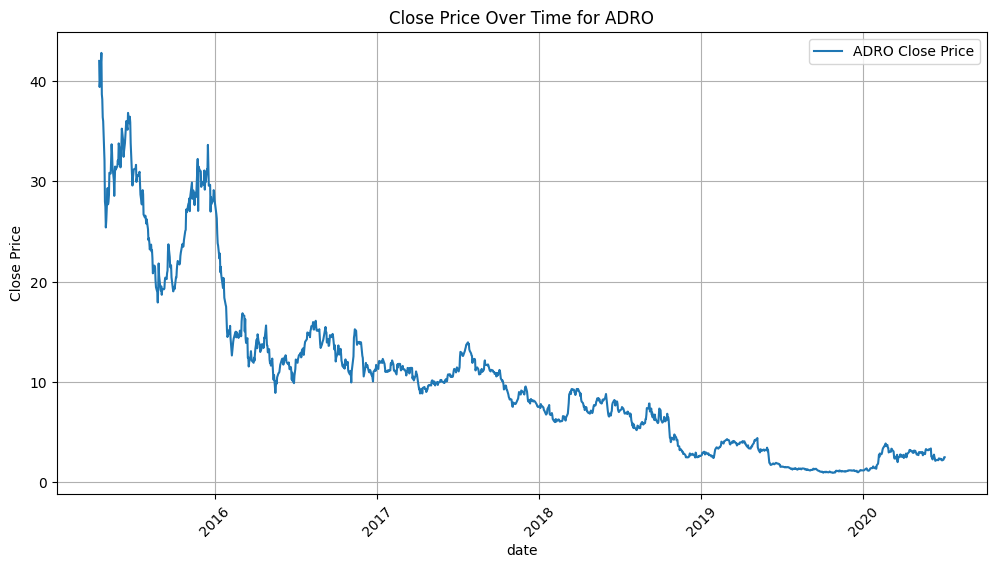

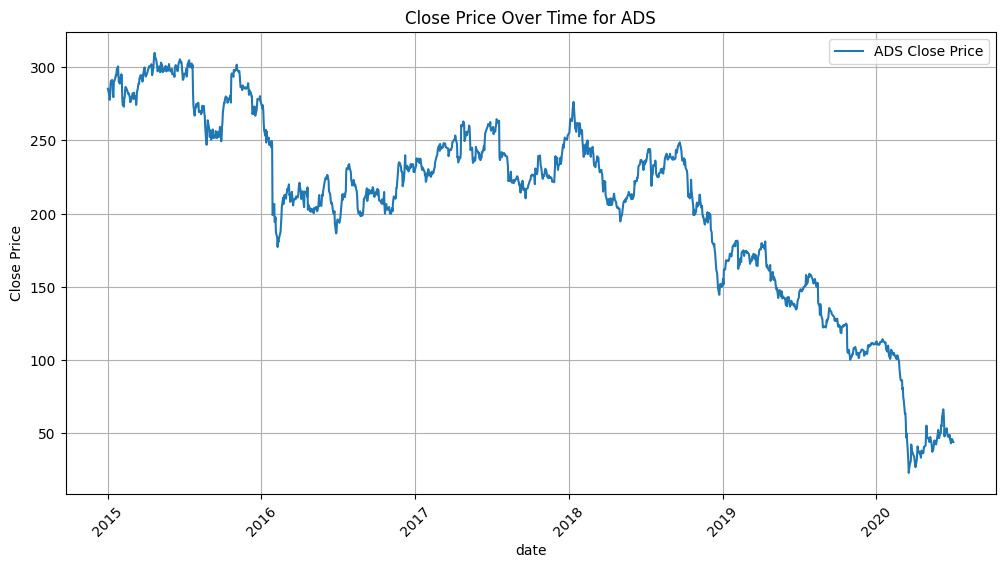

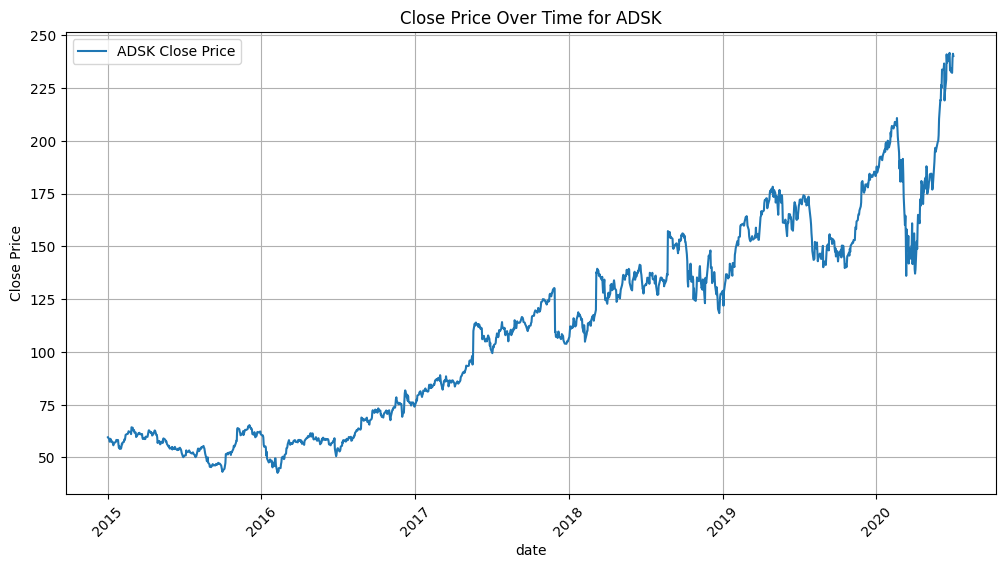

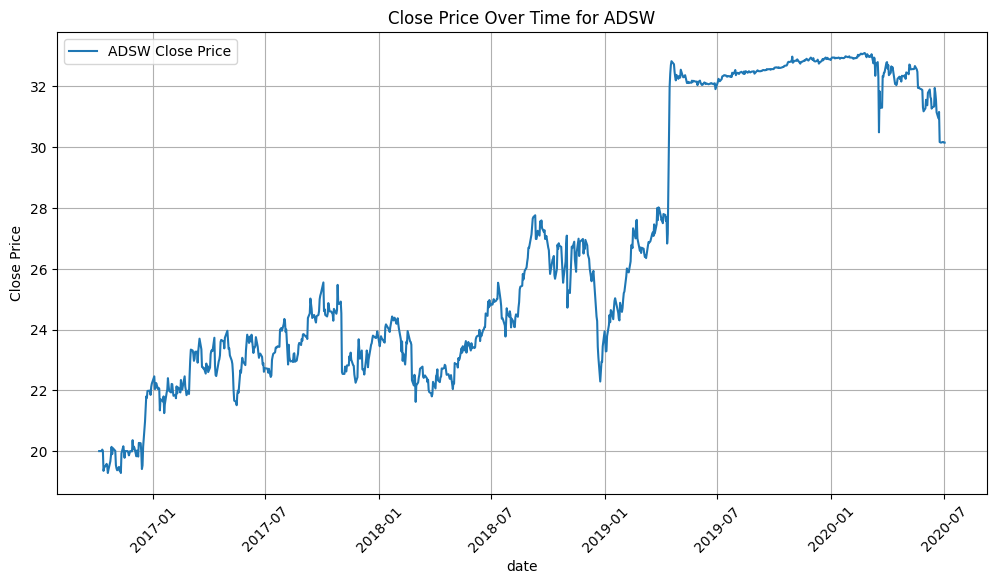

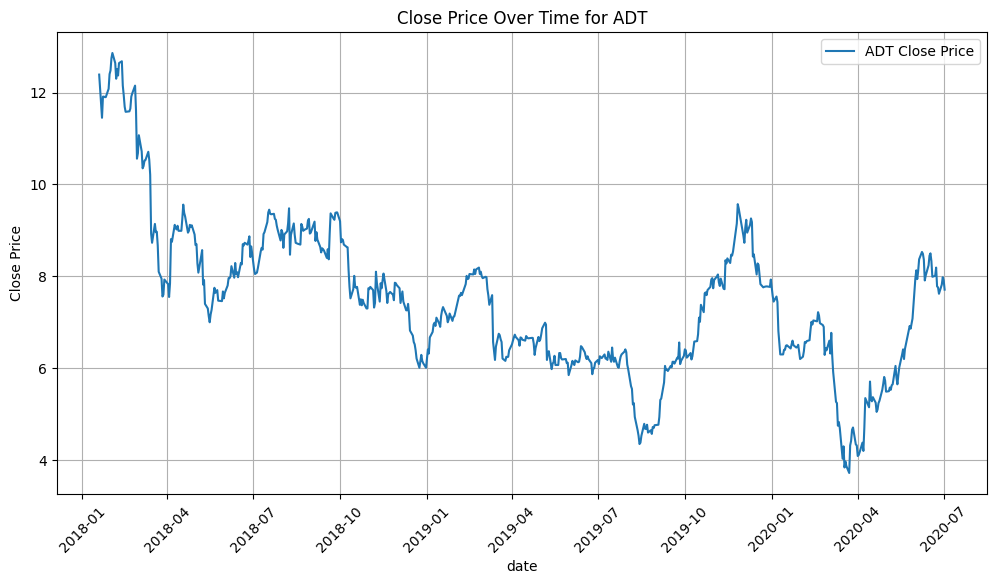

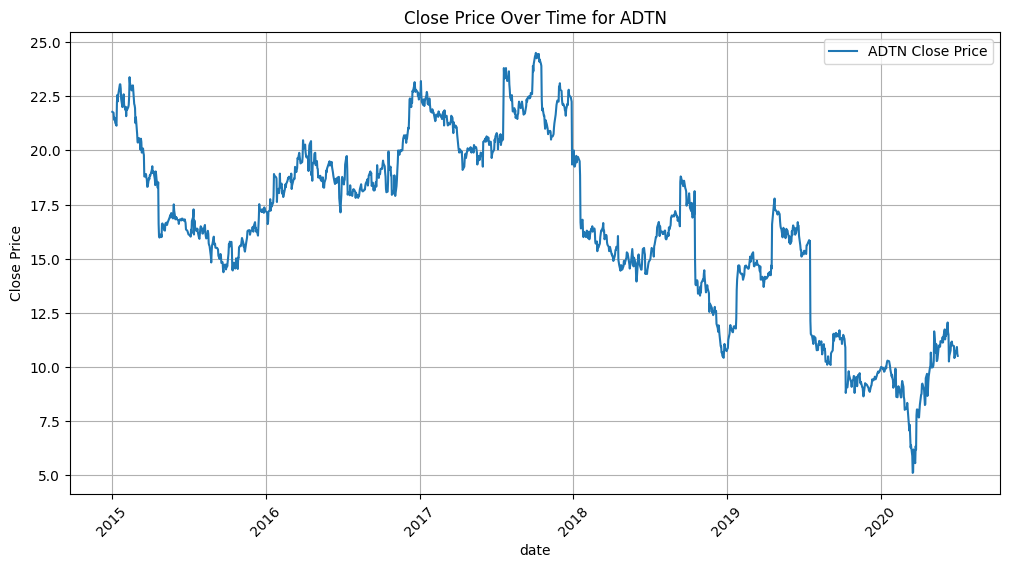

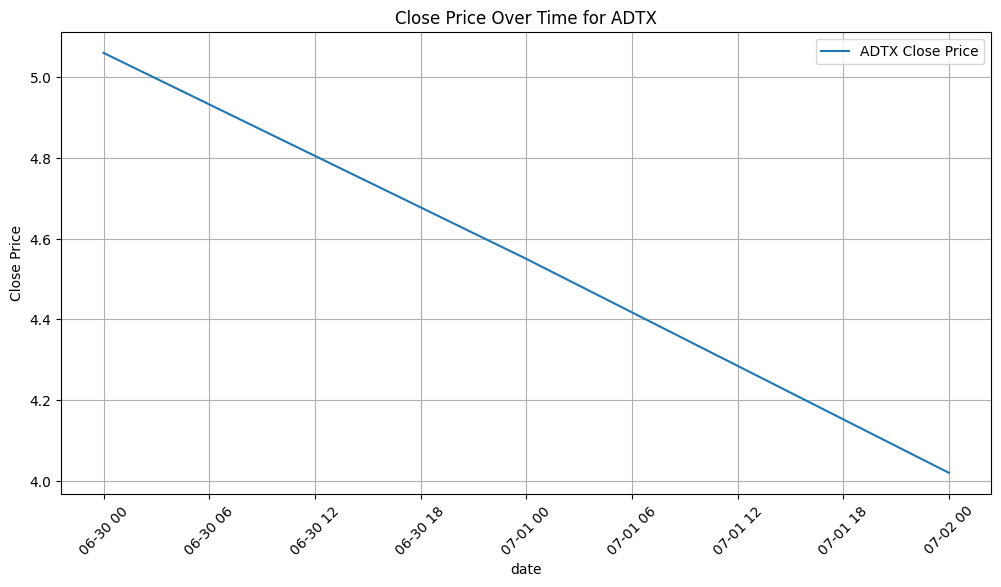

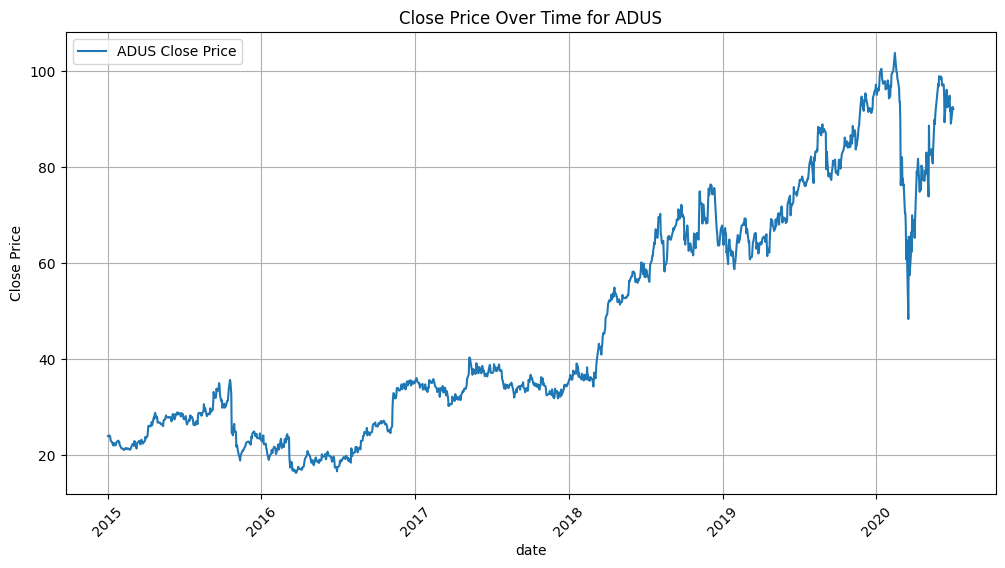

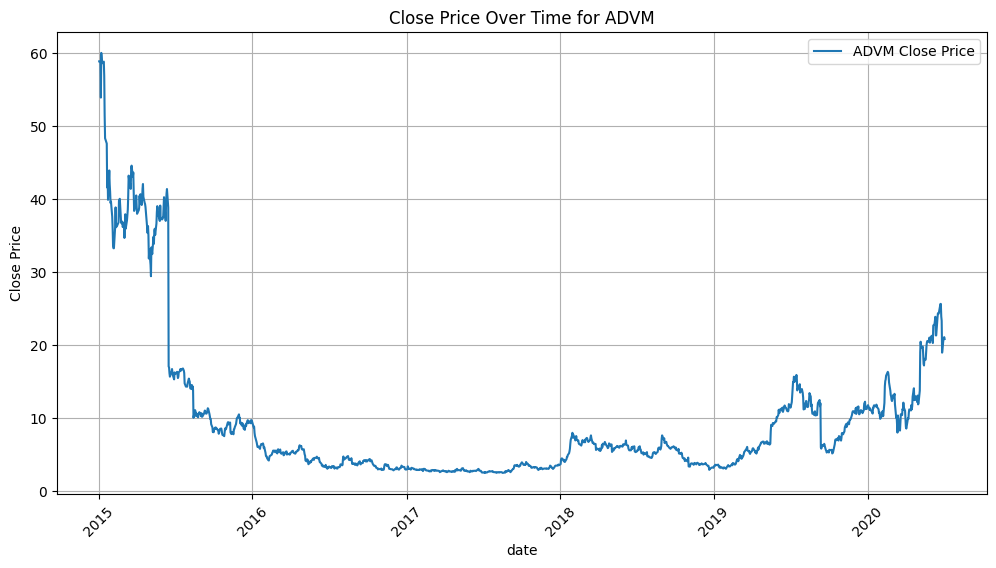

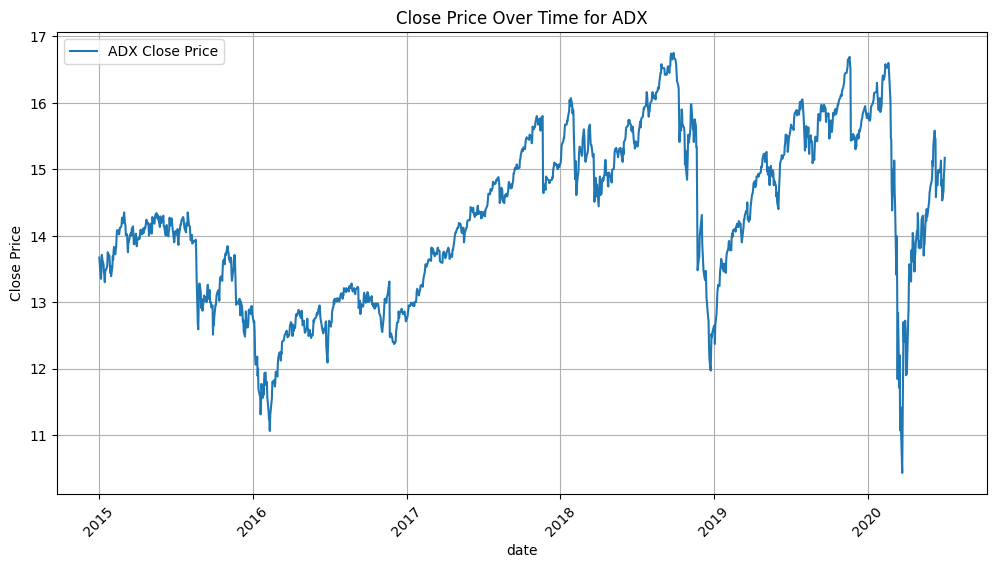

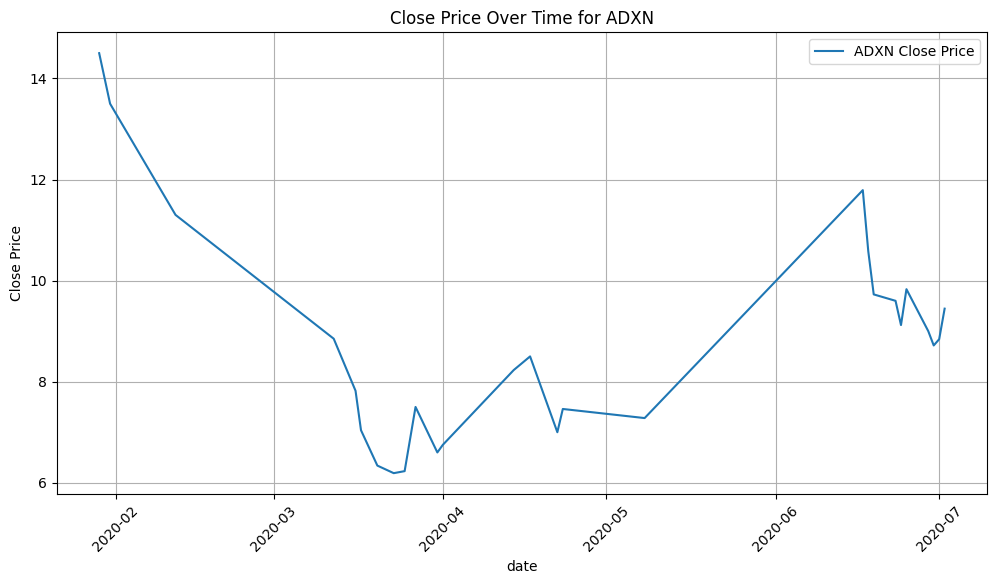

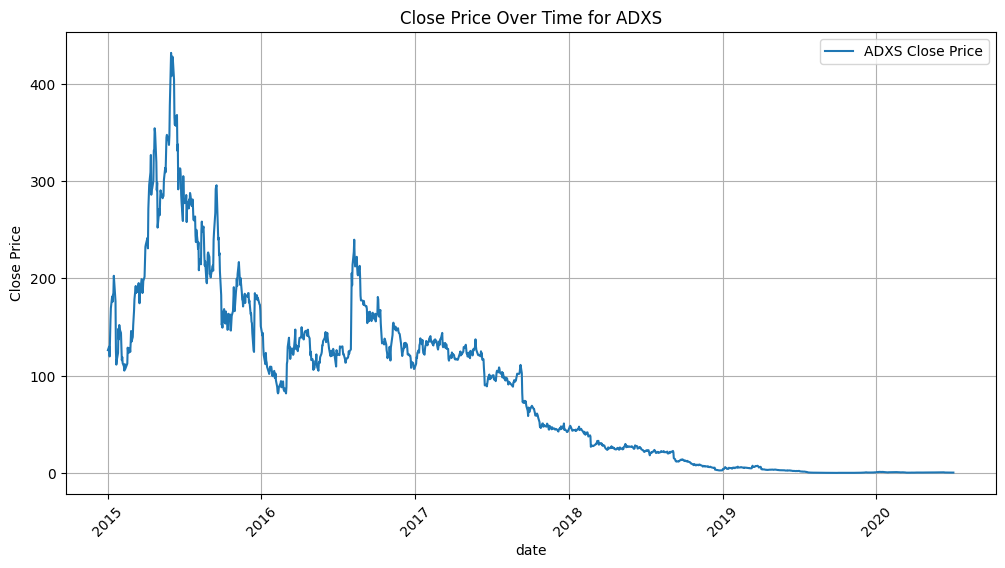

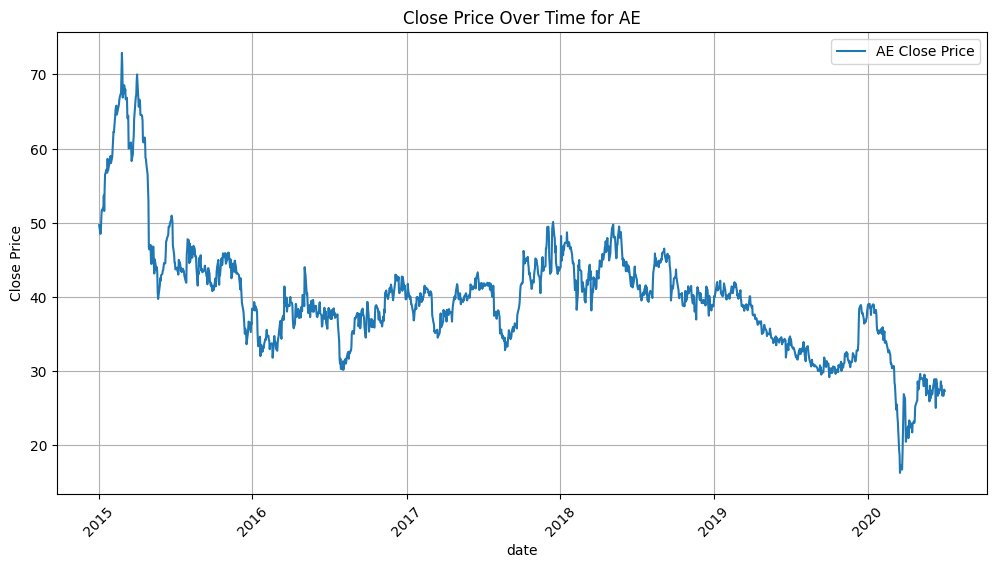

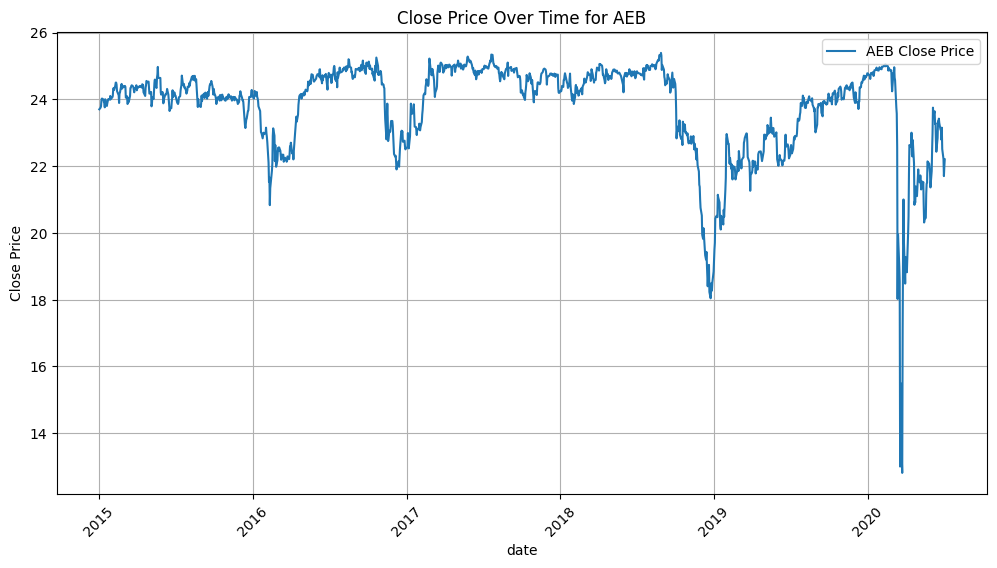

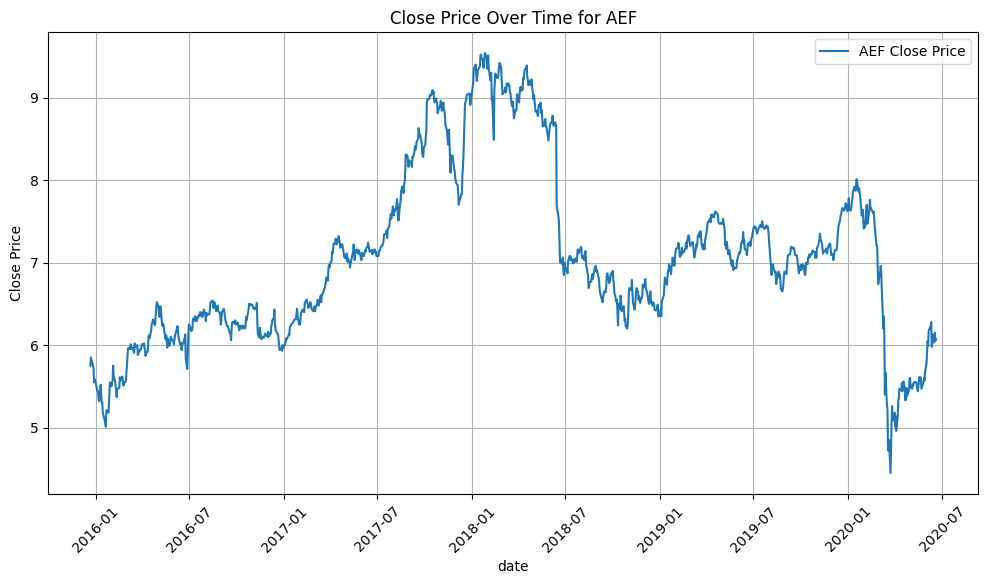

In [9]:
import matplotlib.pyplot as plt

# Unique symbols in the dataset
symbols = pandas_df['symbol'].unique()

# Generate line plots for each symbol
for symbol in symbols:
    firm_data = pandas_df[pandas_df['symbol'] == symbol]
    plt.figure(figsize=(12, 6))
    plt.plot(firm_data['date'], firm_data['close'], label=f"{symbol} Close Price")
    plt.title(f"Close Price Over Time for {symbol}")
    plt.xlabel("date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()


In [10]:
len(pandas_df['symbol'].unique())

#

102

Correlation Analysis Across Companies:

Time Series Analysis with Moving Averages

In [11]:
# Add moving averages to the dataset
pandas_df['MA_20'] = pandas_df['close'].rolling(window=20).mean()
pandas_df['MA_50'] = pandas_df['close'].rolling(window=50).mean()
pandas_df['MA_200'] = pandas_df['close'].rolling(window=200).mean()


## Predictive Analysis

In [12]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg

window_spec_20 = Window.partitionBy("symbol").orderBy("date").rowsBetween(-19, 0)
df = df.withColumn("MA_20", avg("close").over(window_spec_20))

window_spec_50 = Window.partitionBy("symbol").orderBy("date").rowsBetween(-49, 0)
df = df.withColumn("MA_50", avg("close").over(window_spec_50))

window_spec_200 = Window.partitionBy("symbol").orderBy("date").rowsBetween(-199, 0)
df = df.withColumn("MA_200", avg("close").over(window_spec_200))


In [13]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["MA_20", "MA_50", "MA_200", "volume"], outputCol="features")
ml_df = assembler.transform(df).select("features", "close")


In [14]:
train_data, test_data = ml_df.randomSplit([0.8, 0.2], seed=42)


In [15]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="close")
lr_model = lr.fit(train_data)


In [16]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")


RMSE: 125.7907101344559


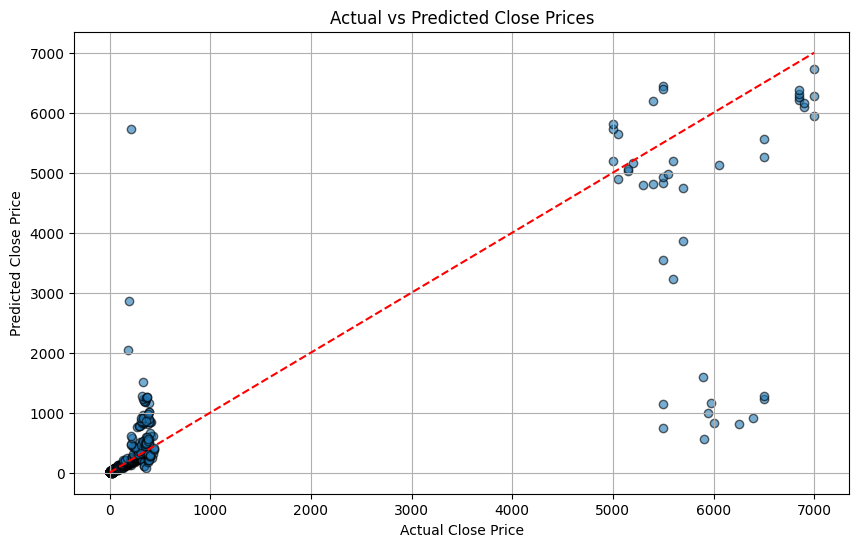

In [17]:
import matplotlib.pyplot as plt

predictions_pd = predictions.select("prediction", "close").toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["close"], predictions_pd["prediction"], alpha=0.6, edgecolors="k")
plt.plot([predictions_pd["close"].min(), predictions_pd["close"].max()],
         [predictions_pd["close"].min(), predictions_pd["close"].max()],
         color="red", linestyle="--")
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.grid(True)
plt.show()


model 2

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

combined_data=df.toPandas()

# Preprocessing: Handling missing values
combined_data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity
combined_data.fillna(method='bfill', inplace=True)  # Backward fill for any remaining

# Convert date to datetime for feature engineering
combined_data['date'] = pd.to_datetime(combined_data['date'])

# Feature engineering: Extracting date-related features
combined_data['day_of_week'] = combined_data['date'].dt.dayofweek
combined_data['month'] = combined_data['date'].dt.month

# Feature engineering: Lag features for 'close' price
combined_data['lag_1_close'] = combined_data.groupby('symbol')['close'].shift(1)
#combined_data['lag_2_close'] = combined_data.groupby('Company')['close'].shift(2)

# Drop rows with NaN values after creating lag features
combined_data.dropna(inplace=True)

# Prepare features and target
features = ['lag_1_close',  'volume', 'open', 'high', 'low', 'day_of_week', 'month']
target = 'close'

X = combined_data[features]
y = combined_data[target]

# Scaling numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Train and evaluate models
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        "Model": model_name,
        "MSE": mse,
        "MAE": mae,
        "R²": r2
    })


<ipython-input-20-9b83fd6bf165>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity
<ipython-input-20-9b83fd6bf165>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='bfill', inplace=True)  # Backward fill for any remaining


In [ ]:
df

DataFrame[date: date, volume: bigint, open: double, high: double, low: double, close: double, adjclose: double, symbol: string]

In [21]:
from pyspark.sql import functions as F

# Add date-related features: day of the week and month
df = df.withColumn("day_of_week", F.dayofweek("date"))
df = df.withColumn("month", F.month("date"))


In [22]:
from pyspark.sql.window import Window

# Define a window partitioned by symbol and ordered by date
window_spec = Window.partitionBy("symbol").orderBy("date")

# Add lag features for 'close' price
df = df.withColumn("lag_1_close", F.lag("close", 1).over(window_spec))
df = df.withColumn("lag_2_close", F.lag("close", 2).over(window_spec))

# Drop rows with NaN values created by lag features
df = df.dropna()


In [23]:
from pyspark.ml.feature import VectorAssembler

# Assemble features into a single column
assembler = VectorAssembler(
    inputCols=["lag_1_close", "lag_2_close", "volume", "open", "high", "low", "day_of_week", "month"],
    outputCol="features"
)
df = assembler.transform(df)


In [24]:
from pyspark.ml.feature import StandardScaler

# Scale features to standardize their range
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)


In [25]:
# Split data into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


In [26]:
from pyspark.ml.regression import RandomForestRegressor

# Initialize and train a Random Forest Regressor
rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="close", predictionCol="prediction")
rf_model = rf.fit(train_df)


In [27]:
# Predict on the test data
predictions = rf_model.transform(test_df)


In [28]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model using RMSE, MAE, and R²
evaluator_rmse = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_mae = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

# Print evaluation results
evaluation_results = {
    "Root Mean Squared Error (RMSE)": rmse,
    "\nMean Absolute Error (MAE)": mae,
    "\nR² Score": r2
}
print(evaluation_results)


{'Root Mean Squared Error (RMSE)': 109.61033106828292, '\nMean Absolute Error (MAE)': 7.709602106580234, '\nR² Score': 0.7843383849818446}


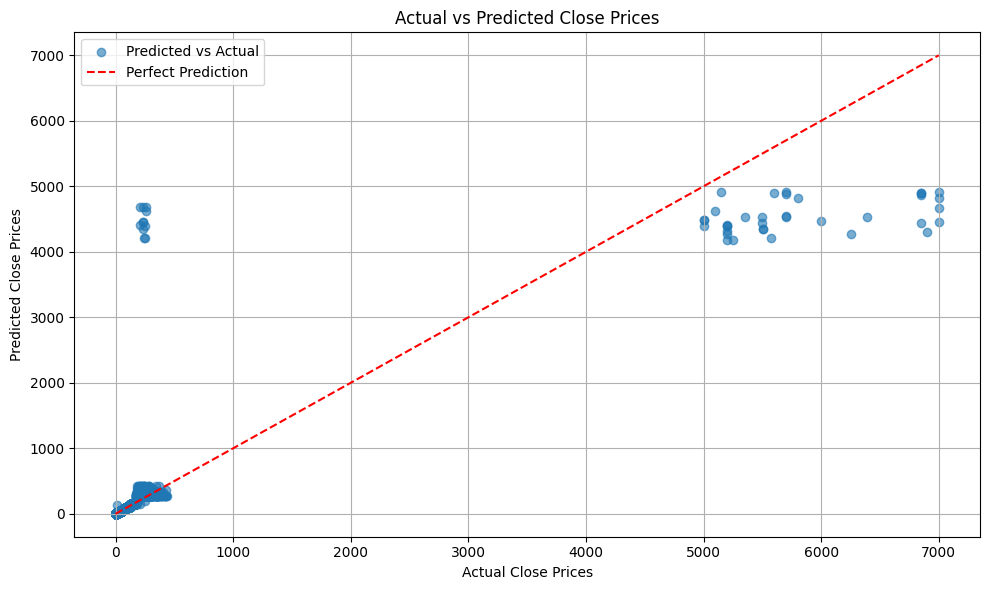

In [29]:
import matplotlib.pyplot as plt

# Convert predictions to Pandas for visualization
predictions_pd = predictions.select("close", "prediction").toPandas()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["close"], predictions_pd["prediction"], alpha=0.6, label="Predicted vs Actual")
plt.plot([predictions_pd["close"].min(), predictions_pd["close"].max()],
         [predictions_pd["close"].min(), predictions_pd["close"].max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Close Prices")
plt.ylabel("Predicted Close Prices")
plt.title("Actual vs Predicted Close Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
